In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import numpy as np
import os
import shutil

Efficiency Analysis (Local-Core)
---------
`Expt1`

In [6]:
# datasets = ["bin_2",  "bin_5", "contact","enron", "congress"]
datasets = ["bin_2",  "bin_5", "contact","enron", "pref", "congress", "dblp", "aminer"]
num_verts = []
wrong_core_numbers = []
wrong_core_perc = []
avg_abserror = []

for data in datasets:
    print(data)
    source_fname = "../output/core_Peel_"+data+".csv"
    target_fname = "../output/wrong_core_"+data+".csv"
    df1 = pd.read_csv(source_fname, header=None)
    df2 = pd.read_csv(target_fname, header=None)

    cnt = 0
    sz = len(df1[0])
    if(len(df1[0])!=len(df2[0])):
        print("Number of vertices do not match")
        exit()
    # print(df1[0])
    # print(sz)
    l1 = [0]*sz
    l2 = [0]*sz

    error = 0
    for i in range(sz):
        if(df1.iat[i,1]!=df2.iat[i,1]):
            cnt+=1
        error += abs(df1.iat[i,1] - df2.iat[i,1])/sz

    num_verts.append(sz)
    wrong_core_numbers.append(cnt)
    wrong_core_perc.append(cnt/sz*100)
    avg_abserror.append(error)

bin_2
bin_5
contact
enron
pref
congress
dblp
aminer


In [7]:
wrong_core_df = pd.DataFrame({'dataset':datasets,'N':num_verts,'#wrongCore':wrong_core_numbers, '%wrongCore':wrong_core_perc})
wrong_core_df = wrong_core_df.replace({"dataset": good_name_dataset})
print(wrong_core_df.head(10))

NameError: name 'good_name_dataset' is not defined

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
# sns.set_style("ticks")
plt.style.use('grayscale')

sns.barplot(x='dataset', y='%wrongCore', data=wrong_core_df, color='k',hue_order=datasets)
plt.xlabel('Dataset', fontsize=fontsize-5)
plt.ylabel('%Nodes with wrong c(v)', fontsize=fontsize-7)
plt.xticks(fontsize=fontsize-7)
plt.yticks(fontsize=fontsize-3)
plt.tight_layout()
plt.savefig('../fig/WrongCore.pdf')
plt.show()

``Expt-2``

In [240]:
# datalist = ['congress','dblp', 'aminer']
datalist = ['pref', 'enron', 'contact','bin_5','bin_2', 'dblp','congress']
# datalist = ['pref', 'enron', 'contact','bin_5','bin_2', 'congress','dblp','aminer']
# datalist = ['pref', 'enron', 'contact','bin_5']
# datalist = ['enron','bin_2']
Xs = []
Ys = [] 
Mean_errors = []
Mean_errors2 = []

def read_iterations_hindices(source):
    source_dicts = {}
    with open(source,'r') as f:
        nodes = []
        i = 0
        for line in f.readlines():
            # line = line.strip()
            if i==0:
                line = line.split(",")
                line = line[:-1]
                for l in line:
                    nodes.append(int(l))
            else:
                source_dicts[i] = {}
                line = line.split(",")
                line = line[:-1]
                for node,l in zip(nodes,line):
                    cv = int(l)
                    source_dicts[i][node] = cv
            i+=1
    return source_dicts

for data in datalist: 
    print(data)
    target = "output/core_Peel_"+data+".csv" # baseline core
    source = "output/log_Local-core_"+data+".csv" # hypergraph h-index
    source2 = "output/wrong_core_log_"+data+".csv" # graph h-index
    target_dict = {} # baseline
    source_dicts = {} # hyp h-index
    source_dicts2 = {} # graph h-index
    correct_perc = {} # % correct core-number at iteration i (hyp h-index)
    mean_errors = {}
    mean_errors2 = {}
    # Read baseline core
    with open(target,'r') as f:
        for line in f.readlines():
            node,cv = line.split(',')
            node = int(node)
            cv = int(cv)
            target_dict[node] = cv 
    
    # Read hyp h-index per iteration
    source_dicts = read_iterations_hindices(source)
    num_iterations_hypHindex = len(source_dicts)+1
    # Read graph h-index per iteration
    source_dicts2 = read_iterations_hindices(source2)
#     with open(source2,'r') as f:
#         nodes = []
#         i = 0
#         for line in f.readlines():
#             # line = line.strip()
#             if i==0:
#                 line = line.split(",")
#                 line = line[:-1]
#                 for l in line:
#                     nodes.append(int(l))
#             else:
#                 source_dicts2[i] = {}
#                 line = line.split(",")
#                 line = line[:-1]
#                 for node,l in zip(nodes,line):
#                     cv = int(l)
#                     source_dicts2[i][node] = cv
#             i+=1
    num_iterations_gHindex = len(source_dicts2)+1
#     print(len(source_dicts),' ',len(source_dicts2))

    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        num_cor = 0
        error = 0
        for k,val in source_dicts[it].items():
            if val == target_dict[k]:
                num_cor+=1
            error += np.abs(val - target_dict[k])
        correct_perc[it] = (num_cor * 100.0)/n
        mean_errors[it] = error/n
    
    
    for it in range(1,num_iterations_gHindex):
        n = len(target_dict)
        error = 0
        for k,val in source_dicts2[it].items():
            error += np.abs(val - target_dict[k])
        mean_errors2[it] = error/n
    
    print('#it(gr): ',num_iterations_gHindex,' #it(hyp):',num_iterations_hypHindex)
    x = sorted(list(correct_perc.keys()))
    y = [correct_perc[i] for i in x]
    Xs.append(x)
    Ys.append(y)
    print(len(mean_errors),' ',len(mean_errors2),' ',len(x))
    Mean_errors.append([mean_errors[i] for i in range(1,num_iterations_hypHindex)])
    Mean_errors2.append([mean_errors2[i] for i in range(1, num_iterations_gHindex)])

pref
#it(gr):  15  #it(hyp): 8
7   14   7
enron
#it(gr):  30  #it(hyp): 11
10   29   10
contact
#it(gr):  16  #it(hyp): 9
8   15   8
bin_5
#it(gr):  11  #it(hyp): 9
8   10   8
bin_2
#it(gr):  10  #it(hyp): 10
9   9   9
dblp
#it(gr):  51  #it(hyp): 53
52   50   52
congress
#it(gr):  36  #it(hyp): 59
58   35   58


In [183]:
print(Xs)
print(Ys)
# print(Mean_errors)
# print(Mean_errors2)

[[1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, 7, 8, 9]]
[[83.7244372810762, 98.64676172314468, 99.88270871067351, 99.97845670196044, 99.99361680058087, 99.99920210007261, 100.0], [59.439294596427764, 87.31630115306353, 92.92335518878589, 95.6364458512322, 97.08342753787022, 98.28170924711735, 98.80171829075289, 99.27650915668099, 100.0, 100.0], [0.6, 1.2, 2.2, 3.4, 4.8, 8.2, 36.8, 100.0], [0.6, 1.2, 1.6, 2.2, 2.6, 3.8, 9.2, 79.0, 100.0]]


In [68]:
print(Mean_errors[-1])
print(Mean_errors2[-1])

[4.228958355566494, 0.31727990260242317, 0.11186238018595271, 0.05344888042879327, 0.029671196060538082, 0.017952233370866537, 0.011554528050807037, 0.00774911847787973, 0.005377339382204905, 0.003854957758810321, 0.002908097371441515, 0.0022313018214130927, 0.0017646776972181143, 0.0014183848815961704, 0.0011314409919220122, 0.0009337927339491102, 0.0007720805228803722, 0.0006468488442749521, 0.0005412186457990761, 0.0004617237541625921, 0.00040509725601057606, 0.0003593604690416401, 0.0003141681676318581, 0.00027659866405023204, 0.00024501850161930003, 0.00021561628142498406, 0.00018893648902643803, 0.00016824603777858605, 0.00015408941324058202, 0.00013775484646596202, 0.00012196476525049603, 0.00010671916959418403, 9.800740064772002e-05, 8.820666058294802e-05, 8.058386275479202e-05, 7.296106492663602e-05, 6.751620933509602e-05, 6.316032486186401e-05, 5.880444038863201e-05, 5.063715700132201e-05, 3.811398914078001e-05, 2.8857734635162007e-05, 2.1234936807006003e-05, 1.36121389788500

# Mean approximation error

In [253]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(10,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]
i = 1
data = datalist[i]
print(good_name_dataset[data])
# for i,data in enumerate(datalist):
#     plt.plot(Xs[i],Mean_errors[i],label=good_name_dataset[data],marker = marker_list[i], color = 'k', markersize = 10)
# fig, ax1 = plt.subplots(figsize=(8,4))
X = range(1,len(Mean_errors2[i])+1)
plt.plot(X,Mean_errors2[i],'.--',marker = marker_list[1], markersize = 5,label='Graph h-index')
# plt.yscale('log')
# plt.ylabel("Avg. error (Hyp. h-index)",fontsize= fontsize-3)
# ax2 = ax1.twinx()
# sns.barplot(Xs[0],Mean_errors[0],color='k')
# ax.legend(loc = 'best', fontsize=labelsize-4,markerscale=1)
# sns.barplot(Xs[i],Mean_errors[i],color='k', ax = ax,alpha = 0.5,label = 'Hyp. h-index')
X = range(1,len(Mean_errors[i])+1)
plt.plot(X,Mean_errors[i],marker = marker_list[1],color = 'k', markersize = 5,label='Hyp. h-index')
# print(Xs[0])
# print(Mean_errors[0])
# print(Mean_errors2[0])
plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Avg. error",fontsize= fontsize)
# plt.yscale('log')
# plt.title(good_name_dataset[data])
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
plt.legend(loc = 'best', fontsize=labelsize-2,markerscale=1)
plt.tight_layout()
plt.savefig('error_hindex_'+good_name_dataset[data]+'.pdf')

aminer


IndexError: list index out of range

bin4U


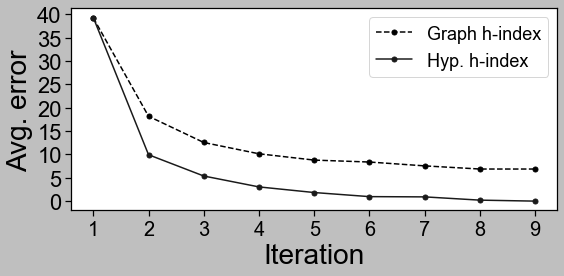

In [107]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]

i = 4
data = datalist[i] 
print(good_name_dataset[data])
X = range(1,len(Mean_errors2[i])+1)
plt.plot(X,Mean_errors2[i],'.--',marker = marker_list[1], markersize = 5,label='Graph h-index')
X = range(1,len(Mean_errors[i])+1)
plt.plot(X,Mean_errors[i],marker = marker_list[1],color = 'k', markersize = 5,label='Hyp. h-index')


plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Avg. error",fontsize= fontsize)
# plt.yscale('log')
# plt.title(good_name_dataset[data])
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
plt.legend(loc = 'best', fontsize=labelsize-2,markerscale=1)
plt.tight_layout()
plt.savefig('error_hindex_'+good_name_dataset[data]+'.pdf')

enron


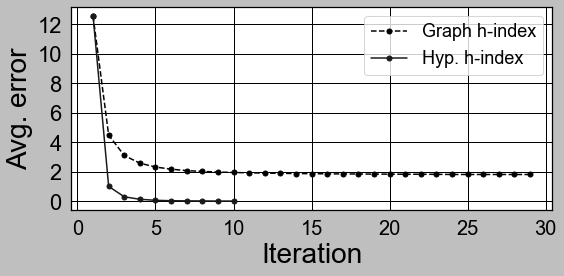

contact


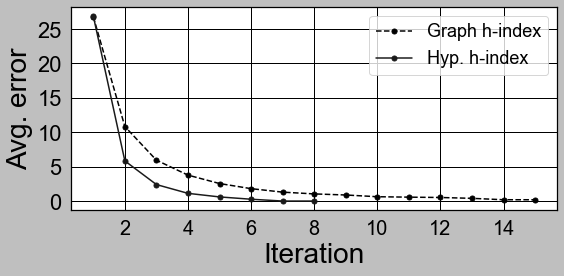

bin3U


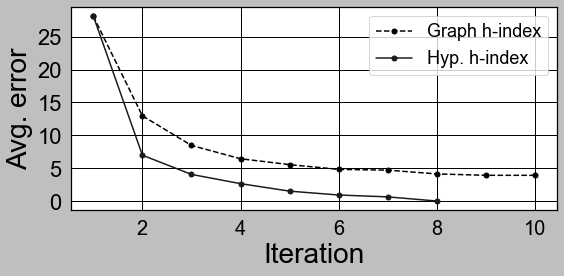

bin4U


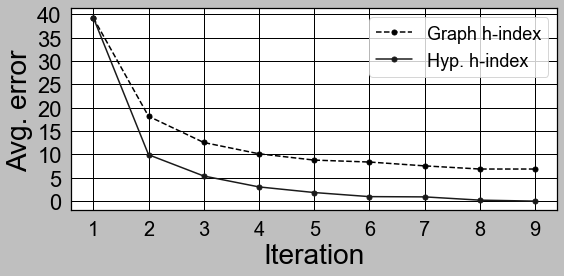

congress


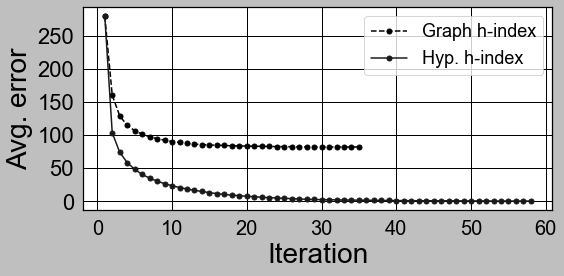

pref3U


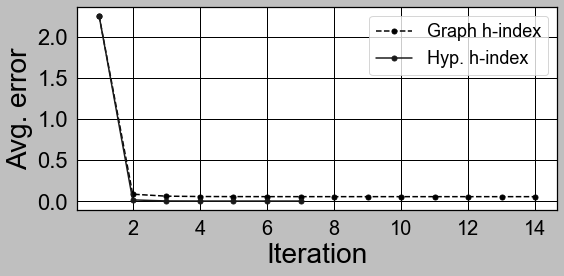

dblp


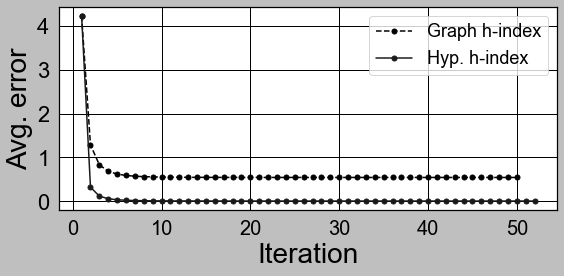

In [105]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid", {'axes.grid' : False})
plt.style.use('grayscale')
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]

for i in range(1, len(datalist)):
#     i = 4
    data = datalist[i] 
    print(good_name_dataset[data])
    X = range(1,len(Mean_errors2[i])+1)
    plt.plot(X,Mean_errors2[i],'.--',marker = marker_list[1], markersize = 5,label='Graph h-index')
    X = range(1,len(Mean_errors[i])+1)
    plt.plot(X,Mean_errors[i],marker = marker_list[1],color = 'k', markersize = 5,label='Hyp. h-index')


    plt.xlabel("Iteration", fontsize=fontsize)
    plt.ylabel("Avg. error",fontsize= fontsize)
    # plt.yscale('log')
    # plt.title(good_name_dataset[data])
    plt.xticks(fontsize=fontsize-8)
    plt.yticks(fontsize=fontsize-6)
    plt.legend(loc = 'best', fontsize=labelsize-2,markerscale=1)
    plt.tight_layout()
    plt.show()
# plt.savefig('error_hindex_'+good_name_dataset[data]+'.pdf')

In [ ]:
datalist = ['pref', 'aminer', 'dblp', 'enron', 'contact','congress', 'bin_5','bin_2' ]
Xs = []
Ys = [] 

def read_iterations_hindices(source):
    source_dicts = {}
    with open(source,'r') as f:
        nodes = []
        i = 0
        for line in f.readlines():
            # line = line.strip()
            if i==0:
                line = line.split(",")
                line = line[:-1]
                for l in line:
                    nodes.append(int(l))
            else:
                source_dicts[i] = {}
                line = line.split(",")
                line = line[:-1]
                for node,l in zip(nodes,line):
                    cv = int(l)
                    source_dicts[i][node] = cv
            i+=1
    return source_dicts

for data in datalist: 
    print(data)
    target = "output/core_Peel_"+data+".csv" # baseline core
    source = "output/log_Local-core_"+data+".csv" # hypergraph h-index
    source2 = "output/wrong_core_log_"+data+".csv" # graph h-index
    target_dict = {} # baseline
    source_dicts = {} # hyp h-index
    source_dicts2 = {} # graph h-index
    correct_perc = {} # % correct core-number at iteration i (hyp h-index)
    mean_errors = {}
    mean_errors2 = {}
    # Read baseline core
    with open(target,'r') as f:
        for line in f.readlines():
            node,cv = line.split(',')
            node = int(node)
            cv = int(cv)
            target_dict[node] = cv 
    
    # Read hyp h-index per iteration
    source_dicts = read_iterations_hindices(source)
    num_iterations_hypHindex = len(source_dicts)+1

    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        num_cor = 0
        for k,val in source_dicts[it].items():
            if val == target_dict[k]:
                num_cor+=1
        correct_perc[it] = (num_cor * 100.0)/n
    
    x = sorted(list(correct_perc.keys()))
    y = [correct_perc[i] for i in x]
    Xs.append(x)
    Ys.append(y)

pref
aminer


In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')

datalist2 = [d for d in datalist
# datalist2 = datalist[:5]
# marker_list = list(Line2D.markers)
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist2)]
for i,data in enumerate(datalist2):
    plt.plot(Xs[i],Ys[i],label=good_name_dataset[data],marker = marker_list[i], color = 'k', markersize = 5)
plt.xscale('log',base=2)
plt.xlabel("Iteration", fontsize=fontsize-4)
plt.ylabel("%Nodes with correct c(v)",fontsize= fontsize-7)
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
plt.legend(loc = 'lower right', fontsize=labelsize-4,markerscale=1)
# plt.legend(loc = 'lower right', fontsize=labelsize-4,markerscale=1,mode = "expand", ncol = 2)
plt.tight_layout()
plt.savefig('fig/Convergence.pdf')

In [133]:
def get_nbrs(dataset):
    _dict = {}
    with open('hgstats/output/setnbrs_'+dataset+'.csv') as rf:
        for line in rf:
            strline = line.strip()
            l = strline.split(',')
            _dict[l[0]] = l[1:]
    return _dict
def get_core(dataset):
    _dict = {}
    with open('output/core_Peel_'+dataset+'.csv') as rf:
        for line in rf:
            strline = line.strip()
            l = strline.split(',')
            _dict[l[0]] = l[1]
    return _dict

In [191]:
d = 'pref'
source_dicts = read_iterations_hindices("output/log_Local-core_"+d+".csv") # hypergraph h-index
dict1 = get_nbrs(d)
core = get_core(d)
dd = {}
converged = []
conv_numnbrs = []
for v in core:
    cv = int(core[v])
    count = 0
    N_v = len(dict1[v])
    if source_dicts[3][int(v)]==cv:
        converged.append(int(v))
        conv_numnbrs.append(N_v)
    for u in dict1[v]:
        cu = core[u]
        if cu != N_v:
            count+=1
    dd[int(v)] = count*100.0/N_v

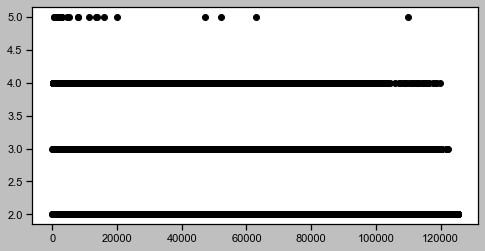

In [188]:
# x = dd.keys()
# y = [dd[i] for i in x]
# plt.plot(x,y)
# plt.title(d)
# plt.show()
# source_dicts[1]
plt.scatter(converged, conv_numnbrs)
plt.show()

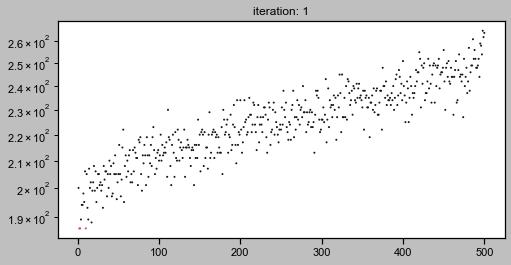

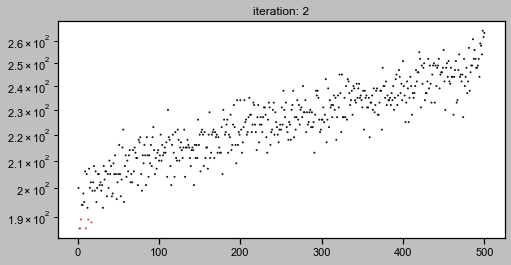

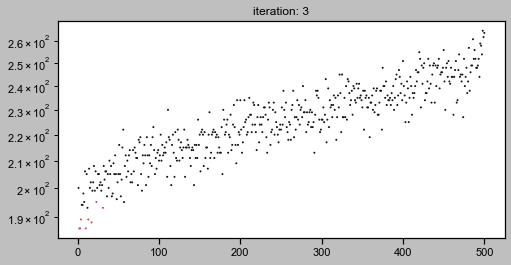

<Figure size 576x288 with 0 Axes>

In [231]:
import numpy as np
from scipy import stats

d = 'bin_2'
source_dicts = read_iterations_hindices("output/log_Local-core_"+d+".csv") # hypergraph h-index
core = get_core(d)
dict1 = get_nbrs(d)
nodes = [v for v in core]
num_nbrs = [len(dict1[v]) for v in nodes]
nodes = [int(v) for v in nodes]
average_nbr_converged = {}
mode_converged = {}
# print(nodes[1],' ',num_nbrs[1])
iterations = sorted(list(source_dicts.keys()))
for it in iterations[:3]:
    colors = []
    conv_numnbrs = []
    for i,v in enumerate(nodes):
        cv = int(core[str(v)])
        if source_dicts[it][v]==cv:
            colors.append('r')
            conv_numnbrs.append(num_nbrs[i])
        else:
            colors.append('k')
    
    average_nbr_converged[it] = np.mean(conv_numnbrs)
    mode_converged[it] = stats.mode(conv_numnbrs)[0]
    plt.scatter(nodes,num_nbrs,color = colors,s=1)
    plt.yscale('log')
    plt.title('iteration: '+str(it))
    plt.show()
    plt.clf()

In [233]:
print(good_name_dataset[d])
print(average_nbr_converged)
print(mode_converged)

bin4U
{1: 186.0, 2: 187.33333333333334, 3: 189.0}
{1: array([186]), 2: array([186]), 3: array([186])}


In [238]:
import numpy as np
from scipy import stats

for d in ['pref', 'enron', 'contact','bin_5','bin_2', 'congress','dblp']:
    source_dicts = read_iterations_hindices("output/log_Local-core_"+d+".csv") # hypergraph h-index
    core = get_core(d)
    dict1 = get_nbrs(d)
    nodes = [v for v in core]
    num_nbrs = [len(dict1[v]) for v in nodes]
    nodes = [int(v) for v in nodes]
    mode_converged = {}
    perc_nodes_lt_mode = {}
    iterations = sorted(list(source_dicts.keys()))
    for it in iterations[:1]:
        colors = []
        conv_numnbrs = []
        for i,v in enumerate(nodes):
            cv = int(core[str(v)])
            if source_dicts[it][v]==cv:
                colors.append('r')
                conv_numnbrs.append(num_nbrs[i])
            else:
                colors.append('k')

        mode_converged[it] = stats.mode(conv_numnbrs)[0]
        
        count= 0
        for i,v in enumerate(nodes):
            if num_nbrs[i]<= mode_converged[it]:
                count+=1
        perc_nodes_lt_mode[it] = count*100.0/len(nodes)
    print(good_name_dataset[d])
    print('mode(#nbrs): ',mode_converged)
    print(perc_nodes_lt_mode)

pref3U
mode(#nbrs):  {1: array([2])}
{1: 75.8738998954751}
enron
mode(#nbrs):  {1: array([1])}
{1: 18.742934659733212}
contact
mode(#nbrs):  {1: array([21])}
{1: 1.2396694214876034}
bin3U
mode(#nbrs):  {1: array([135])}
{1: 0.8}
bin4U
mode(#nbrs):  {1: array([186])}
{1: 0.6}
congress
mode(#nbrs):  {1: array([100])}
{1: 2.4447031431897557}
dblp
mode(#nbrs):  {1: array([2])}
{1: 29.514547565169476}


5 8
['congress', 'pref', 'dblp']
5 congress
6 pref
7 dblp


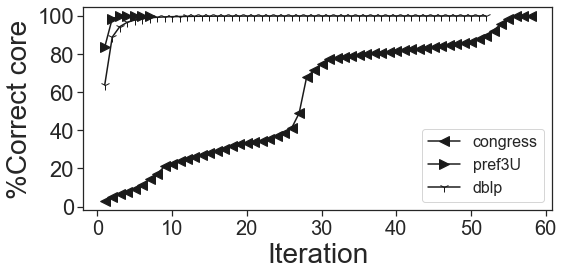

In [168]:
""" Convergence of congress & aminer"""
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid", {'axes.grid' : False})
# plt.style.use('grayscale')
sns.set_style("ticks")


i_s = range(5,len(datalist)+1)
print(i_s[0],i_s[-1])
datalist2 = datalist[i_s[0]:i_s[-1]]
print(datalist2)
marker_list = list(Line2D.markers)
# marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist2)]
for i,data in zip(i_s,datalist2):
    print(i,data)
    plt.plot(Xs[i],Ys[i],label=good_name_dataset[data], marker = marker_list[i], color = 'k', markersize = 10)
plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("%Correct core",fontsize= fontsize)
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
plt.legend(loc = 'best', fontsize=labelsize-4,markerscale=1)
plt.tight_layout()
# plt.savefig('fig/Convergence.pdf')

Efficiency Analysis
-------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import numpy as np
import os
import shutil

output_folder = '../output/'
# output_folder = 'server_output/output/'
# parallel_outfolder = '/Users/nus/Downloads/kcore-openmp-master/server_output/output/'
parallel_outfolder = '../output/parout/'
fontsize = 28
labelsize = 20

In [79]:
df1 = pd.read_csv(output_folder+"results.csv", header = None)
df1.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df2 = pd.read_csv(parallel_outfolder+"results.csv", header = None)
df2.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df2 = df2[df2.num_threads == 64].copy()
df = pd.concat([df1,df2])
print(df.shape)
print(df.dataset.unique())
df.head()

(371, 5)
['enron' 'bin_1' 'bin_2' 'bin_4' 'bin_5' 'congress' 'contact' 'dblp'
 'pref' 'aminer' 'gowalla']


,algo,dataset,execution time,num_threads,total iteration
0,Peel,enron,10.883833,1,0
1,Peel,enron,10.865674,1,0
2,Peel,enron,10.892707,1,0
3,Peel,enron,10.880811,1,0
4,Peel,enron,10.872030,1,0


In [80]:
good_name = {
    'bucket update time' : 'Bucket time (s)', 
    'execution time' : "Execution time (s)", 
    'neighborhood call time' : "NB time (s)", 
    'subgraph computation time' : "Sub time(s)",
    'num bucket update' : "#bucket", 
    'num neighborhood computation' : "#nb",
    'num subgraph call' : "#subgraph",
    'outerloop time': "outloop time(s)",
    'init time': 'init time(s)',
    'total iteration': '#total iterations',
    'inner iteration': '#inner iterations',
    'memory taken': 'Memory (MB)',
    'core_correction time': 'Core-corection time(s)',
    'h_index_time': 'h-index time(s)',
    'sum_core_correction_volume' : 'Sum Core-correction vol',
    'tau': '#Iterations'
    # 'num_threads' : '#Threads'
}

# NBR(1) adopts Arijits simplification to Bishwa's simplification.
good_name_algo = {
    'Peel' : "Peel", 
    'E-Peel': "E-Peel", 
    'Local-core': "Local-core",
    'Local-core-OPTI': "Local+I",
    'Local-core-OPTII': "Local+I+II",
    'Local-core-OPTIII': "Local+I+II+III",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)/64T"
}

good_name_dataset = {
    'bin_2': 'bin4U',
    'bin_5': 'bin3U', 
    'pref': 'pref3U', 
    "enron" : "enron",
    "congress" : "congress",
    "contact" : "contact",
    "dblp": "dblp",
    "syn" : "syn",
    "bin_4" : "bin_4",
    "bin_1" : "bin_1",
    "pref_20000": "pref20000",
    "pref_40000": "pref40000",
    "pref_60000": "pref60000",
    "pref_80000": "pref80000",
    "pref_100000": "pref100000",
    "gowalla": "gowalla",
    'weeplaces':'weeplaces',
    'aminer': 'aminer'
}
order=["Peel", "E-Peel", "Local-core-OPTIV"]
# order=["Peel", "E-Peel", "Local-I","Local-II","Local-III"]
linewidth= 2
scatterplotBall = 150
save = True

### Execution time Plots

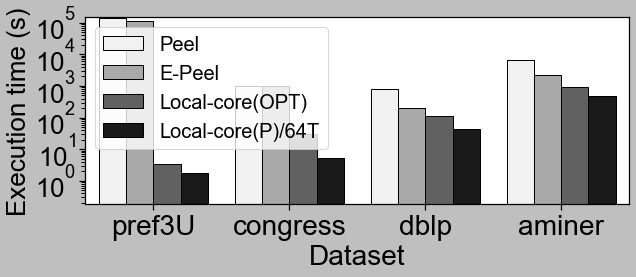

0.1820909 168387.4532052


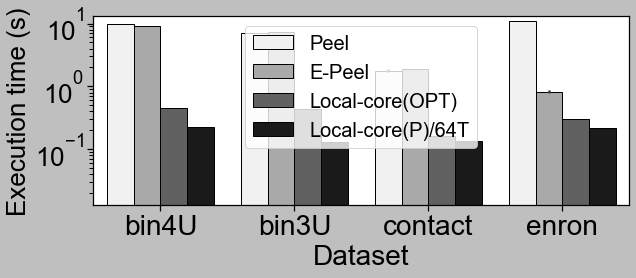

<Figure size 648x288 with 0 Axes>

In [94]:
import matplotlib.pyplot as plt 
import seaborn as sns 
# print(plt.style.available)
sns.set(rc={'figure.figsize':(9,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})
sns.set_style("ticks")
plt.style.use('grayscale')

save = True
markers = ['o',"s",'x']

include_algos = ["Peel", "E-Peel", "Local-core-OPTIV", 'LocalP(B+CSR)2']
ord = [good_name_algo[i] for i in include_algos]
group_list = ['dataset']
include_datasets = ['pref','congress','dblp','aminer']
# include_datasets = ['congress','dblp', 'aminer']
# columns = ['execution time']

working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df = working_df[working_df['num_threads']==1].copy()
# working_df = working_df[working_df['num_threads']==1].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

# print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets, color='k')
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
plt.yscale("log")
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.1)

# plt.title()
# plt.legend(loc = 'upper left', fontsize=labelsize-4, mode = "expand", ncol = 4) # ,bbox_to_anchor =(0.65, 1.25), mode = "expand", ncol = 3
plt.legend(fontsize=labelsize)
# plt.legend(loc = 'upper center', fontsize=labelsize-4,mode = "expand", ncol = 4)
plt.tight_layout()
filename = ("large " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("fig/" + filename + ".pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()

print(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.2)

include_datasets = ['bin_2','bin_5','contact','enron']
# columns = ['execution time']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

# print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='k')
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
plt.yscale("log")
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.2)

plt.legend(fontsize=labelsize, loc = 'upper center')
# plt.legend(loc = 'upper center', fontsize=labelsize-4,mode = "expand", ncol = 4)
plt.tight_layout()
filename = ("small " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("fig/" + filename + ".pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()

Expt-4: Impact of optimizations
--------

dataset   algo               
aminer    Local-core             3371.087095
          Local-core(OPT)         937.384775
          Local-core+I           2783.479406
          Local-core+I+III       1998.153680
          Local-core+I+III+IV    1044.736726
congress  Local-core              149.586972
          Local-core(OPT)          29.441617
          Local-core+I            146.948545
          Local-core+I+III         81.987471
          Local-core+I+III+IV      82.272428
dblp      Local-core              497.859868
          Local-core(OPT)         111.303328
          Local-core+I            435.879310
          Local-core+I+III        242.214225
          Local-core+I+III+IV     126.019723
pref3U    Local-core                8.958250
          Local-core(OPT)           3.478344
          Local-core+I              8.577399
          Local-core+I+III          6.239026
          Local-core+I+III+IV       5.763946
Name: execution time, dtype: float64


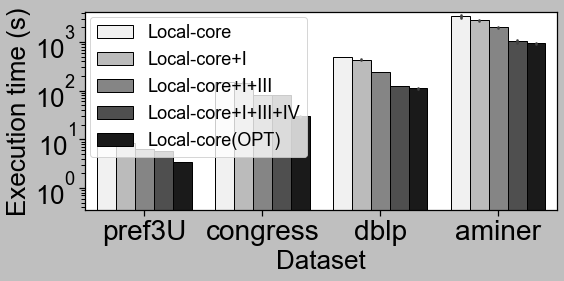

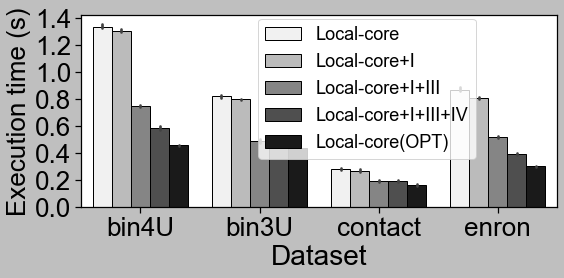

<Figure size 576x288 with 0 Axes>

In [95]:
import matplotlib.pyplot as plt 
# from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')

save = True

good_name_algo = {
    'Peel' : "Peel", 
    'E-Peel': "E-Peel", 
    'Local-core': "Local-core",
    'Local-core-OPTI': "Local-core+I",
    'Local-core-OPTII': "Local-core+I+III",
    'Local-core-OPTIII': "Local-core+I+III+IV",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)/64T"
}

include_algos = ['Local-core', 'Local-core-OPTI','Local-core-OPTII', 'Local-core-OPTIII', 'Local-core-OPTIV']
ord = [good_name_algo[i] for i in include_algos]
group_list = ['dataset']
# include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
include_datasets = ['pref','congress','dblp', 'aminer']
# columns = ['execution time']

working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df[working_df['num_threads']==1].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='k')
plt.xlabel('Dataset', fontsize=fontsize-2)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.1)
# plt.title()
plt.legend(loc = 'upper left', fontsize=labelsize-2, bbox_to_anchor=(-0.01,1.02))

plt.tight_layout()
filename = ("large " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("fig/" + filename + "_opt.pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()


include_datasets = ['bin_2','bin_5','contact','enron']
# columns = ['execution time']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

# print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='k')
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
# plt.yscale("log")
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)

plt.legend(loc = 'upper center', fontsize=labelsize-2, bbox_to_anchor=(0.6,1.03))
plt.tight_layout()
filename = ("small " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("fig/" + filename + "_opt.pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()

Expt-5 (Impact of Parallelization)
----------

``Impact of #Threads``

In [42]:
good_name_algo = {
    'Peel' : "vs. Peel", 
    'E-Peel': "vs. E-Peel", 
    'Local-core': "Local",
    'Local-core-OPTI': "Local(I)",
    'Local-core-OPTII': "Local(II)",
    'Local-core-OPTIII': "Local(III)",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)"
}

In [43]:
df1 = pd.read_csv(output_folder+"results.csv", header = None)
df1.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df2 = pd.read_csv(parallel_outfolder+"results.csv", header = None)
df2.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df = pd.concat([df1,df2])
df.head()

,algo,dataset,execution time,num_threads,total iteration
0,Peel,enron,10.883833,1,0
1,Peel,enron,10.865674,1,0
2,Peel,enron,10.892707,1,0
3,Peel,enron,10.880811,1,0
4,Peel,enron,10.872030,1,0


In [474]:
# import matplotlib.pyplot as plt 
# from matplotlib.ticker import MaxNLocator
# import seaborn as sns 
# sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})
# # plt.style.use('grayscale')

# save = False

# include_algos = ['LocalP(B+CSR)2']
# reference_algs = ['Local-core-OPTIV'] # Reference against.
# col = ['r','g','b']
# group_list = ['dataset']
# # include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
# # include_datasets = ['bin_2','bin_5','contact','enron', 'congress']
# include_datasets = ['dblp', 'aminer']
# # columns = ['execution time']

# tmp = df[df['dataset'].isin(include_datasets)].copy()
# working_df = df[df['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# # working_df['param_s'] = working_df['param_s'].astype(int)
# working_df = working_df.replace({"algo": good_name_algo})
# working_df = working_df.replace({"dataset": good_name_dataset})
# include_datasets = [good_name_dataset[d] for d in include_datasets]
# y_axis = 'execution time'  

# graph = None
# for dp in include_datasets:
#     working_df2 = working_df[working_df.dataset == dp].copy()
#     if len(working_df2)==0:
#         continue 
#     # print(working_df2.groupby(['num_threads'])['execution time'].mean())
#     # _min = working_df[y_axis].min()
#     # donotdrawline = working_df[y_axis].max() <= 20*_min
#     # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
#     graph = sns.barplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
#     # graph = sns.scatterplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
    
#     df4 = tmp[tmp['algo'].isin(reference_algs)].copy()
#     for i,alg in enumerate(reference_algs):
#         # print(df4[df4.algo == alg])
#         mean = df4[ (df4.algo == alg) & (df4.dataset==dp)]['execution time'].mean()
#         # df4.groupby(['dataset','algo'])['execution time'].mean()
#         graph.axhline(mean,label = good_name_algo[alg],color = col[i])
        
#     plt.xlabel('num_threads', fontsize=fontsize)
#     plt.ylabel(good_name[y_axis], fontsize=fontsize)
#     # plt.yscale("log")
#     plt.xticks(fontsize=fontsize)
#     plt.yticks(fontsize=fontsize)
#     plt.title(dp)
#     plt.legend(loc = 'upper center', fontsize=labelsize)
#     plt.tight_layout()
#     filename = (dp + y_axis).replace(" ", "_")
#     if(save):
#         plt.savefig("fig/" + filename + ".pdf")
#     else:
#         print(filename)
#         plt.show()
#     plt.clf()


# # include_datasets = ['bin_2','bin_5','contact','enron']
# # # columns = ['execution time']
# # working_df = df[df['dataset'].isin(include_datasets)].copy()
# # working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# # # working_df['param_s'] = working_df['param_s'].astype(int)
# # # working_df = working_df.replace({"algo": good_name_algo})
# # working_df = working_df.replace({"dataset": good_name_dataset})
# # include_datasets = [good_name_dataset[d] for d in include_datasets]
# # y_axis = 'execution time'  

# # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# # # _min = working_df[y_axis].min()
# # # donotdrawline = working_df[y_axis].max() <= 20*_min
# # # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
# # ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind', hue_order = order, order = include_datasets)
# # ax.yaxis.set_major_locator(MaxNLocator(5)) 
# # plt.xlabel('Dataset', fontsize=fontsize)
# # plt.ylabel(good_name[y_axis], fontsize=fontsize)
# # # plt.yscale("log")
# # plt.xticks(fontsize=fontsize)
# # plt.yticks(fontsize=fontsize)
# # # plt.
# # # ()
# # plt.legend(loc = 'upper center', bbox_to_anchor=(0.6,1), fontsize=labelsize-6)
# # plt.tight_layout()
# # filename = ("small " + y_axis).replace(" ", "_")
# # if(save):
# #     plt.savefig("results_final/fig/" + filename + ".pdf")
# # else:
# #     print(filename)
# #     plt.show()
# # plt.clf()



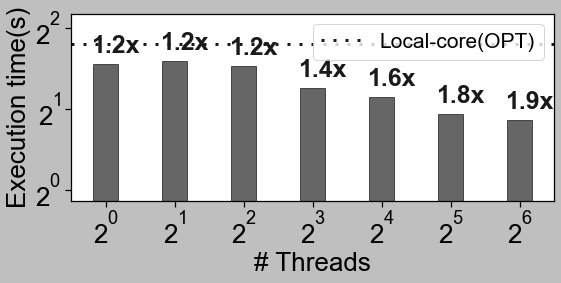

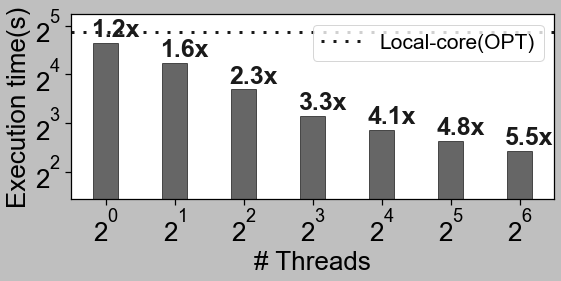

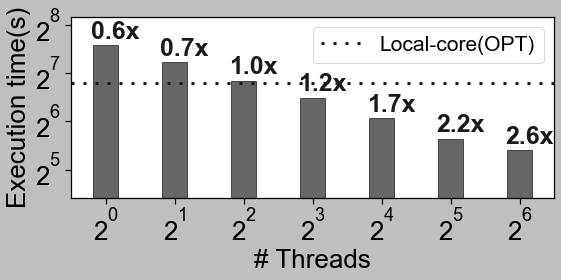

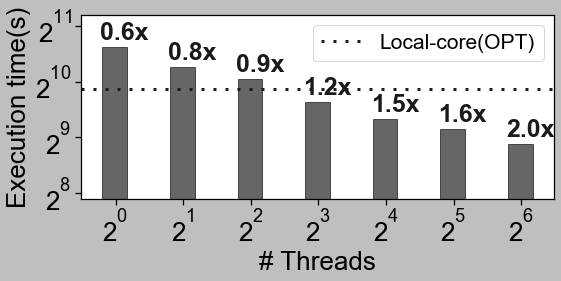

<Figure size 576x288 with 0 Axes>

In [77]:
from matplotlib import pyplot as plt 
from matplotlib.ticker import MaxNLocator
# import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
plt.style.use('grayscale')

save = True

include_algos = ['LocalP(B+CSR)2']
reference_algs = ['Local-core-OPTIV'] # Reference against.
col = ['r','g','b']
markers = ['o',"s",'x']
group_list = ['dataset']
# include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
# include_datasets = ['bin_2','bin_5','contact','enron', 'congress']
# include_datasets = ['congress','dblp', 'aminer', 'gowalla','pref']
include_datasets = ['pref','congress','dblp', 'aminer']
# include_datasets = ['gowalla']
# columns = ['execution time']

tmp = df[df['dataset'].isin(include_datasets)].copy()
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

graph = None
df4 = tmp[tmp['algo'].isin(reference_algs)].copy()
df4 = df4.replace({"dataset": good_name_dataset})
thread_lim = 7
for dp in include_datasets:
    for i,alg in enumerate(reference_algs):
        ref_mean = df4[ (df4.algo == alg) & (df4.dataset==dp)]['execution time'].mean()
        # print(df4[ (df4.algo == alg) & (df4.dataset==dp)])
        working_df2 = working_df[working_df.dataset == dp].copy()
        # print(working_df2[y_axis])
        working_df2['speedup']  = ref_mean/ working_df2[y_axis]
        if len(working_df2)==0:
            continue 
        # print(working_df2)
        # print(working_df2.groupby(['num_threads'])['execution time'].mean())
        # _min = working_df[y_axis].min()
        # donotdrawline = working_df[y_axis].max() <= 20*_min
        # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
        # graph = sns.barplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
        # graph = sns.scatterplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
        # sns.lineplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind', marker = markers[i], label = alg)
        # plt.plot(working_df2['num_threads'][:thread_lim], working_df2[y_axis][:thread_lim],marker = markers[i], label = good_name_algo[alg],color = 'k')
        plt.bar(x = working_df2['num_threads'][:thread_lim], height = working_df2[y_axis][:thread_lim], width = working_df2['num_threads'][:thread_lim]/4, alpha = 0.6)
        for i,v in enumerate(working_df2['num_threads'][:thread_lim]):
            speedup = "{:.1f}x".format(ref_mean/ working_df2[y_axis][:thread_lim].values[i])
            # print(working_df2[y_axis][:thread_lim].values[i], speedup)
            plt.text(v-working_df2['num_threads'][:thread_lim].values[i]/7, working_df2[y_axis][:thread_lim].values[i]*1.1,str(speedup) , \
                     color='k', fontweight='bold',fontsize = fontsize-3)

            
        # plt.xticks(working_df2['num_threads'])
        # print(working_df2['num_threads'].values)
        # if i==0:
        # print(working_df2[y_axis])
        # print(working_df2['num_threads'])
        plt.axhline(ref_mean,color = 'k',linestyle = '--',dashes=(1, 3), label = good_name_algo[alg],linewidth = 3)
        plt.xlabel('# Threads', fontsize=fontsize-2)
        # plt.ylabel("Speedup", fontsize=fontsize)
        plt.ylabel('Execution time(s)', fontsize=fontsize-2)
        plt.yscale("log",base = 2)
        plt.xscale("log", base=2)
        plt.xticks(fontsize=fontsize-2)
        plt.yticks(fontsize=fontsize-2)
        # plt.title(dp)
    plt.legend(loc = 'upper right', fontsize=labelsize+1)
    # if dp!='pref':
    plt.ylim(np.min(working_df2[y_axis][:thread_lim].values)/2, np.max(working_df2[y_axis][:thread_lim].values)*1.5)
    # else:    
    #     plt.ylim(32, np.max(working_df2[y_axis][:thread_lim].values)*1.5)
    
    plt.tight_layout()
    filename = "parallel_time_"+dp
    if(save):
        plt.savefig("fig/" + filename + ".pdf")
    else:
        print(filename)
    plt.show()
    plt.clf() 
        

    # include_datasets = ['bin_2','bin_5','contact','enron']
    # # columns = ['execution time']
    # working_df = df[df['dataset'].isin(include_datasets)].copy()
    # working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    # # working_df['param_s'] = working_df['param_s'].astype(int)
    # # working_df = working_df.replace({"algo": good_name_algo})
    # working_df = working_df.replace({"dataset": good_name_dataset})
    # include_datasets = [good_name_dataset[d] for d in include_datasets]
    # y_axis = 'execution time'  

    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
    # # _min = working_df[y_axis].min()
    # # donotdrawline = working_df[y_axis].max() <= 20*_min
    # # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
    # ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind', hue_order = order, order = include_datasets)
    # ax.yaxis.set_major_locator(MaxNLocator(5)) 
    # plt.xlabel('Dataset', fontsize=fontsize)
    # plt.ylabel(good_name[y_axis], fontsize=fontsize)
    # # plt.yscale("log")
    # plt.xticks(fontsize=fontsize)
    # plt.yticks(fontsize=fontsize)
    # # plt.
    # # ()
    # plt.legend(loc = 'upper center', bbox_to_anchor=(0.6,1), fontsize=labelsize-6)
    # plt.tight_layout()
    # filename = ("small " + y_axis).replace(" ", "_")
    # if(save):
    #     plt.savefig("results_final/fig/" + filename + ".pdf")
    # else:
    #     print(filename)
    #     plt.show()
    # plt.clf()


``Impact of Load-balancing``

In [ ]:
df_par = pd.read_csv(parallel_outfolder+"results.csv", header = None)
df_par.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df_par = df_par[df_par.num_threads.isin([1,2,4,8,16,32,64])].copy()
# df_par.head(60)
df_par_nolb = pd.read_csv(parallel_outfolder+"results_nolb.csv", header = None)
df_par_nolb.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"] 
df_tmp = pd.merge(df_par,df_par_nolb,how = 'inner', on=['dataset','num_threads'])
df_tmp['speedup'] = df_tmp['execution time_y']/df_tmp['execution time_x']
selected_df = df_tmp[df_tmp.dataset.isin(['congress','pref','aminer','dblp'])]
selected_df.groupby(by=['dataset'])['speedup'].describe()

### Expt-3: Efficiency Analysis of E-Peel vs Peel

In [270]:
df = pd.read_csv("output/nbrq_results.csv", header = None,delimiter=' ')
# df = pd.read_csv("epeel_ana/output/nbrq_results.csv", header = None,delimiter=' ')
df.columns = ['algo', 'dataset', 'execution time', "n_nbr_q"]
# df.head()

include_datasets = ['bin_5','dblp', 'enron', 'bin_2','contact', 'congress', 'aminer', 'pref']
epeel_df = df[df.algo == 'E-Peel'].copy()
# print(epeel_df)
peel_df = df[df.algo == 'Peel'].copy()
# print(peel_df)
epeel_df['alpha'] = epeel_df['n_nbr_q'].values/peel_df['n_nbr_q'].values
epeel_df['Speedup'] = peel_df['execution time'].values/epeel_df['execution time'].values
print(epeel_df.head(8))

      algo   dataset  execution time   n_nbr_q     alpha    Speedup
1   E-Peel     enron        0.833050      6737  0.384708  13.964719
3   E-Peel     bin_2        9.619980     27342  0.875000   1.123539
5   E-Peel     bin_5        7.802935     29132  1.013851   0.965231
7   E-Peel  congress     1090.318320    215997  1.007900   0.995327
9   E-Peel   contact        2.020313      8405  1.029646   0.951831
11  E-Peel      dblp      203.730784   2776754  0.641252   4.099650
13  E-Peel    aminer     2133.391792  30817693  0.698891   3.323541
15  E-Peel      pref   115106.413864    355091  1.308840   1.187574


[',', '.', 'o', 'v', '^', '<', '>', 'X']


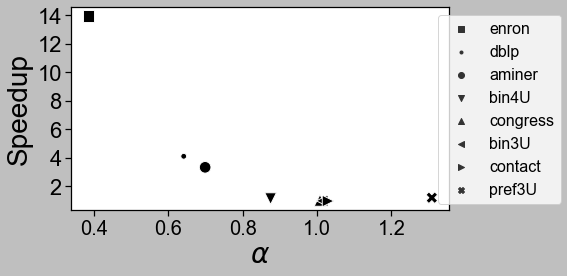

In [276]:
import matplotlib.pyplot as plt 
# from matplotlib.lines import Line2D
# from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')

epeel_df = epeel_df.sort_values('alpha')
# epeel_df = epeel_df.replace({"algo": good_name_algo})
epeel_df = epeel_df.replace({"dataset": good_name_dataset})
# marker_list = list(Line2D.markers)
marker_list = [',', '.', 'o', 'v', '^', '<', '>','X','8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', ]
print(marker_list[:len(epeel_df)])
ax = sns.scatterplot(x='alpha', y='Speedup', data=epeel_df, style='dataset', markers = marker_list[:len(epeel_df)], s= 135)
# plt.xticks([0.3,0.7,0.9,0.95,1.1])
ax.set_xlabel(r"${\alpha}$", fontsize=fontsize)
ax.set_ylabel("Speedup",fontsize= fontsize)
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
# plt.legend(loc = 'best', fontsize=labelsize-4, markerscale=2, mode = "expand", ncol = 4)
plt.legend(loc = 'upper left', fontsize=labelsize-4, bbox_to_anchor=(0.95,1))
plt.tight_layout()
plt.savefig('fig/Epeel_exp.pdf')

In [13]:
epeel_df.head()

,algo,dataset,execution time,n_nbr_q,alpha,Speedup
1,E-Peel,enron,0.833050,6737,0.384708,13.964719
11,E-Peel,dblp,203.730784,2776754,0.641252,4.099650
13,E-Peel,aminer,2133.391792,30817693,0.698891,3.323541
3,E-Peel,bin4U,9.619980,27342,0.875000,1.123539
7,E-Peel,congress,1090.318320,215997,1.007900,0.995327


`Explaining the differences in alpha values across dataset`

In [274]:
sum_diff_core_lb = {}
mean_diff_core_lb = {}
sum_diff_nv_lb = {}
mean_diff_nv_lb = {}
sum_diff_maxnu_lb = {}
mean_diff_maxnu_lb = {}
sum_diff_maxcu_lb = {}
mean_diff_maxcu_lb = {}

sum_diff_nv_core = {}
mean_diff_nv_core = {}
sum_diff_maxnu_core = {}
mean_diff_maxnu_core = {}
sum_diff_maxcu_core = {}
mean_diff_maxcu_core = {}

cnt_diff_core_lb = {}
cnt_diff_nv_lb = {}
cnt_diff_maxnu_lb = {}
cnt_diff_maxcu_lb = {}
meancnt_diff_core_lb = {}
meancnt_diff_nv_lb = {}
meancnt_diff_maxnu_lb = {}
meancnt_diff_maxcu_lb = {}

for d in ['bin_5','dblp', 'enron', 'bin_2','contact', 'congress']:
    fname = 'epeel_ana/output/'+d+'_lb.csv'
    df = pd.read_csv(fname)
    df.columns = ['id','lb','core','nv','max_nu','max_cu']

    sum_diff_core_lb[good_name_dataset[d]] = (df['core'] - df['lb']).sum()
    mean_diff_core_lb[good_name_dataset[d]] = (df['core'] - df['lb']).mean()
    sum_diff_nv_lb[good_name_dataset[d]] = (df['nv']-df['lb']).sum()
    mean_diff_nv_lb[good_name_dataset[d]] = (df['nv']-df['lb']).mean()
    sum_diff_maxnu_lb[good_name_dataset[d]] = (df['max_nu']-df['lb']).sum()
    mean_diff_maxnu_lb[good_name_dataset[d]] = (df['max_nu']-df['lb']).mean()
    sum_diff_maxcu_lb[good_name_dataset[d]] = (df['max_cu']-df['lb']).sum()
    mean_diff_maxcu_lb[good_name_dataset[d]] = (df['max_cu']-df['lb']).mean()

    sum_diff_nv_core[good_name_dataset[d]] = (df['nv'] - df['core']).sum()
    mean_diff_nv_core[good_name_dataset[d]] = (df['nv'] - df['core']).mean()
    sum_diff_maxnu_core[good_name_dataset[d]] = (df['max_nu'] - df['core']).sum()
    mean_diff_maxnu_core[good_name_dataset[d]] = (df['max_nu'] - df['core']).mean()
    sum_diff_maxcu_core[good_name_dataset[d]] = (df['max_cu'] - df['core']).sum()
    mean_diff_maxcu_core[good_name_dataset[d]]= (df['max_cu'] - df['core']).mean()

    cnt_diff_core_lb[good_name_dataset[d]] = (df['core']>df['lb']).sum()
    cnt_diff_nv_lb[good_name_dataset[d]] = (df['nv'] > df['lb']).sum()
    cnt_diff_maxnu_lb[good_name_dataset[d]] = (df['max_nu'] > df['lb']).sum()
    cnt_diff_maxcu_lb[good_name_dataset[d]] = (df['max_cu'] > df['lb']).sum()
    meancnt_diff_core_lb[good_name_dataset[d]] = (df['core']>df['lb']).sum()/len(df['core'])
    meancnt_diff_nv_lb[good_name_dataset[d]] = (df['nv'] > df['lb']).sum()/len(df['core'])
    meancnt_diff_maxnu_lb[good_name_dataset[d]] = (df['max_nu'] > df['lb']).sum()/len(df['core'])
    meancnt_diff_maxcu_lb[good_name_dataset[d]] = (df['max_cu'] > df['lb']).sum()/len(df['core'])

In [277]:
# sum_diff_core_lb
# sum_diff_nv_lb
# sum_diff_maxnu_lb
# sum_diff_maxcu_lb
# sum_diff_nv_core
# cnt_diff_nv_lb
meancnt_diff_nv_lb # ***
# cnt_diff_core_lb
# meancnt_diff_core_lb
# cnt_diff_nv_lb

{'bin3U': 0.9979959919839679,
 'dblp': 0.40071817684356104,
 'enron': 0.4357756671189507,
 'bin4U': 0.9939879759519038,
 'contact': 0.995850622406639,
 'congress': 0.9994175888177053}

[0.38470762905436273, 0.6412524675511824, 1.0138511867474072, 0.875, 1.0296459634938135, 1.0078999925339704]
      data     alpha     nv_lb    speedup
0    enron  0.384708  0.435776  13.964719
1     dblp  0.641252  0.400718   4.099650
2    bin3U  1.013851  0.997996   0.965231
3    bin4U  0.875000  0.993988   1.123539
4  contact  1.029646  0.995851   0.951831


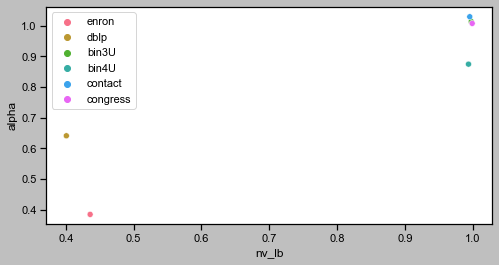

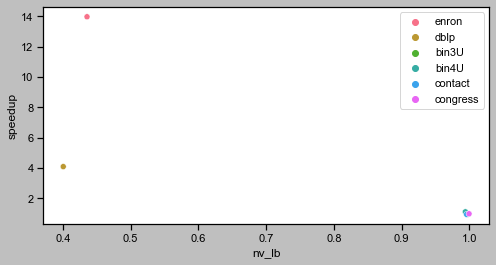

<Figure size 576x288 with 0 Axes>

In [280]:
# marker_list = [',', '.', 'o', 'v', '^', '<', '>','X','8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P']
_tmp = ['enron', 'dblp', 'bin_5', 'bin_2','contact', 'congress']
_tmp2 = [good_name_dataset[d] for d in _tmp]
alpha_f = [epeel_df[epeel_df.dataset== d].alpha.values[0] for d in _tmp2]
speedup = [epeel_df[epeel_df.dataset== d].Speedup.values[0] for d in _tmp2]
print(alpha_f)
_tmpdf = pd.DataFrame(columns=['data','alpha','nv_lb','speedup'])
_tmpdf.data = _tmp2; _tmpdf.alpha = alpha_f; _tmpdf.nv_lb = [meancnt_diff_nv_lb[d] for d in _tmp2]; _tmpdf.speedup = speedup
print(_tmpdf.head())
sns.scatterplot(x='nv_lb',y='alpha',data = _tmpdf,hue = 'data',markers = marker_list[:len(_tmpdf)])
plt.legend()
plt.show()
plt.clf()
sns.scatterplot(x='nv_lb',y='speedup',data = _tmpdf,hue = 'data',markers = marker_list[:len(_tmpdf)])
plt.legend()
plt.show()
plt.clf()

In [281]:
mean_diff_core_lb

{'bin3U': 5.969939879759519,
 'dblp': 0.30727188084471535,
 'enron': 0.1653098145635459,
 'bin4U': 0.0,
 'contact': 21.809128630705395,
 'congress': 191.12521840419336}

In [283]:
# mean_max_nu

In [619]:
mean_max_cu

{'bin3U': 6.0,
 'dblp': 10.261151206444534,
 'enron': 10.878109452736318,
 'bin4U': 0.0,
 'contact': 27.0,
 'congress': 253.3954571927781}

In [285]:
# mean_epeeldf = df1[df1.algo == 'E-Peel'].groupby('dataset')['execution time'].mean()
# mean_epeeldf

In [286]:
sum_diff_core_lb = {}
mean_diff_core_lb = {}
sum_diff_nv_lb = {}
mean_diff_nv_lb = {}
sum_diff_maxnu_lb = {}
mean_diff_maxnu_lb = {}
sum_diff_maxcu_lb = {}
mean_diff_maxcu_lb = {}

sum_diff_nv_core = {}
mean_diff_nv_core = {}
sum_diff_maxnu_core = {}
mean_diff_maxnu_core = {}
sum_diff_maxcu_core = {}
mean_diff_maxcu_core = {}

cnt_diff_core_lb = {}
cnt_diff_nv_lb = {}
cnt_diff_maxnu_lb = {}
cnt_diff_maxcu_lb = {}
meancnt_diff_core_lb = {}
meancnt_diff_nv_lb = {}
meancnt_diff_maxnu_lb = {}
meancnt_diff_maxcu_lb = {}

nodewise_q = {} 
df_summary = {}
for d in ['bin_5','dblp', 'enron', 'bin_2','contact', 'congress']:
    fname = 'output/'+d+'_epeellb.csv'
    df = pd.read_csv(fname)
    df.columns = ['id','lb','core','nv','max_nu','max_cu','Nu_gt_Nv','Nu_gt_cv','Nu_gt_lbv','lbu_gt_lbv','cu_gt_cv','cu_gt_lbv']
    df_summary[d] = df 
    nodewise_q[d] = {}
    fname2 = 'output/'+d+'_peelnodeQ.csv'
    df = pd.read_csv(fname2)
    df.columns = ['v','freq']

    fname2 = 'output/'+d+'_epeelnodeQ.csv'
    df2 = pd.read_csv(fname2)
    df2.columns = ['v','freq']
    # print(df.head())
    for k,v in df.iterrows():
        nodewise_q[d][v[0]] = [int(v[1])]
    for k,v in df2.iterrows():
        nodewise_q[d][v[0]].append(int(v[1]))

In [290]:
df_summary.keys()

dict_keys(['bin_5', 'dblp', 'enron', 'bin_2', 'contact', 'congress'])

In [748]:
# d = 'enron'
# _tmpdf = pd.DataFrame(columns=['v','peel','epeel'])
# fname2 = 'output/'+d+'_peelnodeQ.csv'
# df = pd.read_csv(fname2)
# df.columns = ['v','freq']
# _tmpdf.v = df.v 
# _tmpdf.peel = [nodewise_q[d][v][0]+1 for v in df.v]
# _tmpdf.epeel = [nodewise_q[d][v][1]+1 for v in df.v]
# _tmpdf['diff'] = _tmpdf.peel - _tmpdf.epeel
# _tmpdf.head()


,v,peel,epeel,diff
0,3,42,6,36
1,150,1,1,0
2,151,3,2,1
3,64,41,10,31
4,153,1,1,0


In [753]:
# print(len(_tmpdf))
# _tmpdf.sort_values('diff')

4422


,v,peel,epeel,diff
136,224,1,2,-1
115,1310,1,2,-1
2908,7037,1,2,-1
2486,7777,1,2,-1
924,3159,1,2,-1
...,...,...,...,...
2384,132,215,1,214
87,7,218,1,217
15,116,285,67,218
1503,57,557,54,503


In [287]:
 df_summary['enron'].head(10)

,id,lb,core,nv,max_nu,max_cu,Nu_gt_Nv,Nu_gt_cv,Nu_gt_lbv,lbu_gt_lbv,cu_gt_cv,cu_gt_lbv
0,3,21,23,136,919,24,30,90,93,82,40,85
1,150,4,4,4,136,24,4,4,4,4,4,4
2,151,11,11,18,435,24,12,13,13,12,12,12
3,64,24,24,129,934,24,59,115,115,0,0,0
4,153,1,1,1,136,23,1,1,1,1,1,1
5,154,24,24,42,501,24,27,32,32,0,0,0
6,155,17,17,29,501,24,18,23,23,15,15,15
7,156,6,6,7,136,24,5,5,5,4,5,5
8,157,1,1,1,136,23,1,1,1,1,1,1
9,158,1,1,1,136,23,1,1,1,1,1,1


C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


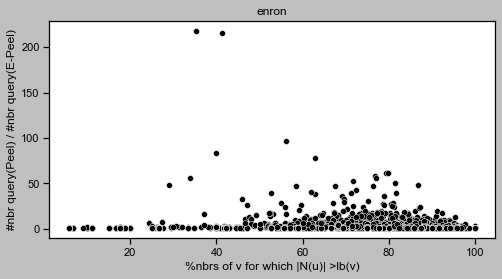

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


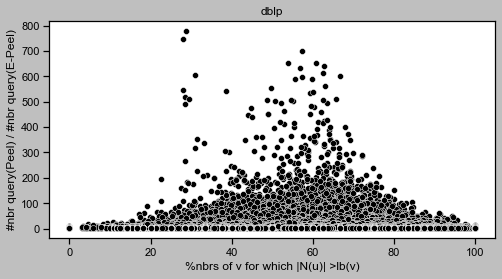

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


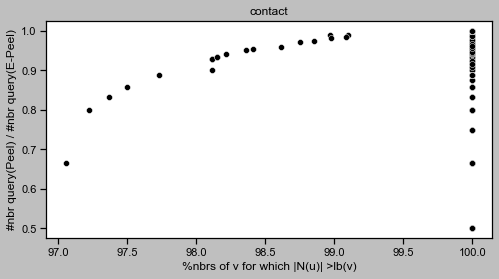

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


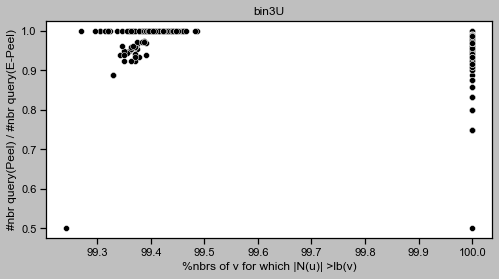

<Figure size 576x288 with 0 Axes>

In [292]:
# for d in ['enron', 'dblp', 'bin_2', 'bin_5', 'contact', 'congress','pref']:
for d in ['enron','dblp', 'contact','bin_5']:
    y = 'Nu_gt_lbv'
    # y = 'lbu_gt_lbv'
#     y = 'cu_gt_cv'
    df_summary[d]['diff'] = [( (nodewise_q[d][_id][0]+1) / (nodewise_q[d][_id][1]+1)) for _id in df_summary[d].id]
    # df_summary[d]['perc'] = (df_summary[d]['nv'] - df_summary[d][y])*100/df_summary[d]['nv']
    df_summary[d]['perc'] = (df_summary[d][y])*100/df_summary[d]['nv']
    df_summary[d].head()
    # x = 'cu_gt_cv'
    # x = 'diff'
    x = 'perc'
    # x = 'id'
    # y = 'Nu_gt_cv'
    # 
    y = 'diff'
    # y = 'perc'
    # x = 'core'
    sns.scatterplot(x,y, data=df_summary[d])
    # sns.scatterplot(x,y, data=df_summary[d],hue = 'cu_gt_cv')
    plt.ylabel('#nbr query(Peel) / #nbr query(E-Peel)')
    # plt.ylabel(r' $|\{|N(u)| > lb[v]: u \in N(v)\}$')
    plt.xlabel('%nbrs of v for which |N(u)| >lb(v)')
    # plt.xlim(-1,5)
    plt.title(good_name_dataset[d])
    plt.show()
    plt.clf()
# d = 'bin_2'
# df_summary[d]['diff'] = [(nodewise_q[d][_id][0] - nodewise_q[d][_id][1]) for _id in df_summary[d].id]
# df_summary[d].head()
# x = 'diff'
# # y = 'Nu_gt_cv'
# y = 'Nu_gt_lbv'
# sns.scatterplot(x,y, data=df_summary[d])
# plt.xlabel('#nbr_query(peel)- #nbr_query(epeel)')
# plt.ylabel('#Nbr > lb')

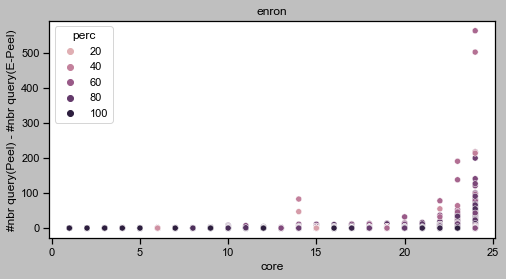

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


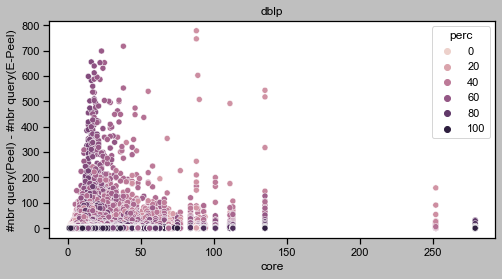

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


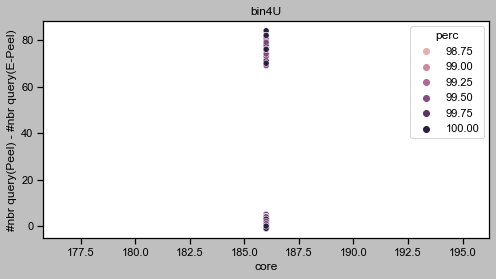

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


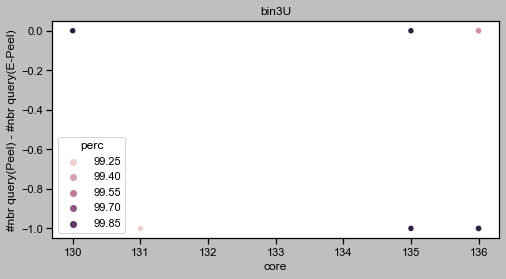

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


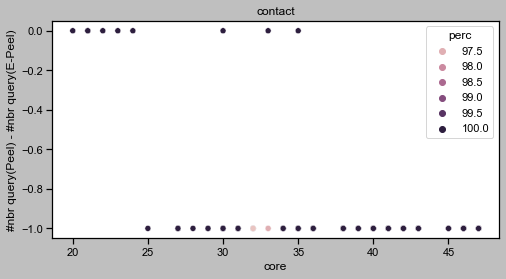

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


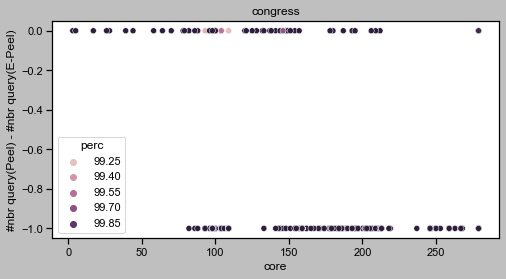

<Figure size 576x288 with 0 Axes>

In [296]:
for d in ['enron', 'dblp', 'bin_2', 'bin_5', 'contact', 'congress']:
    x = 'core'
    df_summary[d]['diff'] = [( (nodewise_q[d][_id][0]+1) - (nodewise_q[d][_id][1]+1)) for _id in df_summary[d].id]
    df_summary[d]['perc'] = (df_summary[d]['Nu_gt_lbv'])*100/df_summary[d]['nv']
    y = 'diff'
    sns.scatterplot(x,y, data=df_summary[d],hue='perc')
    # sns.scatterplot('id','core', data=df_summary[d])
    plt.ylabel('#nbr query(Peel) - #nbr query(E-Peel)')
    plt.title(good_name_dataset[d])
    plt.show()
    plt.clf()

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


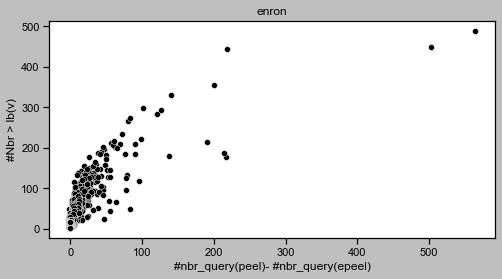

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


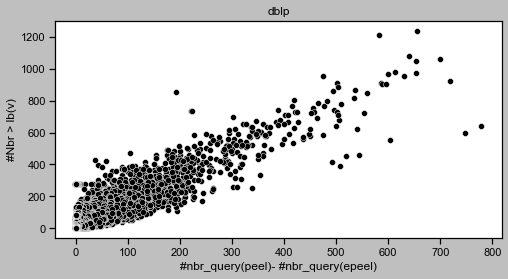

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


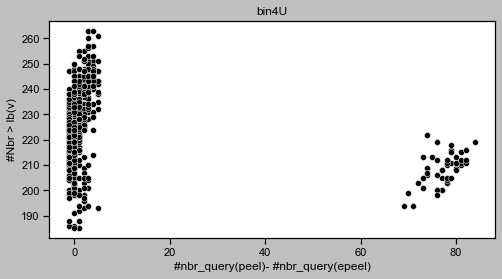

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


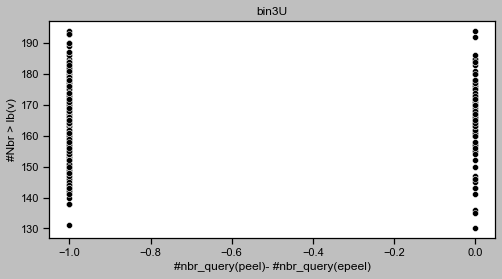

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


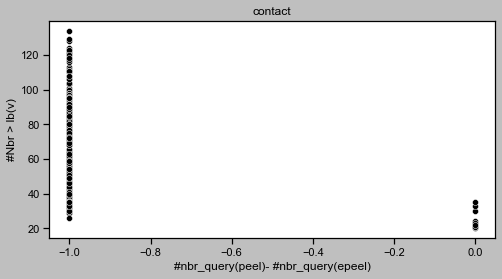

C:\Users\naheedanjum.arafat\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


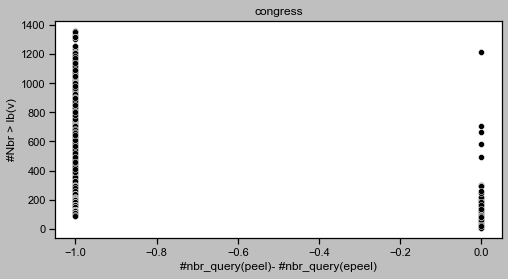

<Figure size 576x288 with 0 Axes>

In [300]:
for d in ['enron', 'dblp', 'bin_2', 'bin_5', 'contact', 'congress']:
    x = 'diff'
    # y = 'Nu_gt_cv'
    y = 'Nu_gt_lbv'
    sns.scatterplot(x,y, data=df_summary[d])
    plt.xlabel('#nbr_query(peel)- #nbr_query(epeel)')
    plt.ylabel('#Nbr > lb(v)')
    plt.title(good_name_dataset[d])
    plt.show()
    plt.clf()

In [127]:
# # ratio between #neighbourhood recomputations
# from matplotlib import pyplot as plt 
# import seaborn as sns 
# sns.set(rc={'figure.figsize':(7,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})

# # save = True


# sns.set(rc={'figure.figsize':(7,4)})
# sns.set(font='serif')
# sns.set_style("whitegrid", {'axes.grid' : True})

# order=["Peel", "E-Peel"]
# include_algos = order
# include_datasets = ['bin_5', 'bin_2','contact', 'enron']
# # columns = ['bucket update time', 'neighborhood call time', 'subgraph computation time', 'num neighborhood computation']
# columns = ['num neighborhood computation']
# # Synthetic dataset
# working_df = df[df['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['ratio(subg.time,total)'] = working_df['subgraph computation time']/working_df['execution time']
# working_df['param_s'] = working_df['param_s'].astype(int)
# working_df = working_df.replace({"algo": good_name_algo})
# working_df = working_df.replace({"dataset": good_name_dataset})
# include_datasets = [good_name_dataset[d] for d in include_datasets]
# print(working_df.algo.unique())

# nb_datasets = []
# nb_alphas = []
# nb_ets = [] 
# for y_axis in columns:
#     if y_axis == 'num neighborhood computation':
#         X = [] 
#         Alpha = []
#         mean_exectime_ratio = []
#         for key, item in working_df.groupby('dataset', as_index=False):
#             peel_nb = item[item.algo == 'Peel'][y_axis]
#             peel_nb = pd.to_numeric(peel_nb)
#             peel_et = pd.to_numeric(item[item.algo == 'Peel']['execution time']).mean()

#             epeel_nb = item[item.algo == 'E-Peel'][y_axis]
#             epeel_nb = pd.to_numeric(epeel_nb)
#             epeel_et = pd.to_numeric(item[item.algo == 'E-Peel']['execution time']).mean()

#             alpha = np.divide(epeel_nb.values,peel_nb.values)
#             X.append(key)
#             Alpha.append(alpha[0]) # Every run gives the same value for #nb.
#             mean_exectime_ratio.append(epeel_et/peel_et)
        
#         sns.barplot(x = X, y = Alpha, order = include_datasets, color='k')
#         plt.xlabel('Dataset', fontsize=fontsize)
#         plt.ylabel(r"${\alpha}$", fontsize=fontsize)
#         plt.xticks(fontsize=fontsize)
#         plt.yticks(fontsize=fontsize)
#         # plt.legend(loc = 'best', fontsize=fontsize)
#         plt.tight_layout()
#         filename = "small_alpha"
#         if(save):
#             plt.savefig("results_final/fig/" + filename + ".pdf")
#         else:
#             print(filename)
#             plt.show()
#         plt.clf()

#         nb_datasets += X 
#         nb_alphas += Alpha
#         nb_ets += mean_exectime_ratio
#         # sns.lineplot(x = mean_exectime_ratio, y = Alpha)
#         # plt.xlabel('exec time ratio', fontsize=fontsize)
#         # plt.ylabel(r"${\alpha}$", fontsize=fontsize)
#         # plt.xticks(fontsize=fontsize)
#         # plt.yticks(fontsize=fontsize)
#         # # plt.legend(loc = 'best', fontsize=fontsize)
#         # plt.tight_layout()
#         # filename = "small_alphavset"
#         # if(save):
#         #     plt.savefig("results_final/fig/" + filename + ".pdf")
#         # else:
#         #     print(filename)
#         #     plt.show()
#         # plt.clf()
#         # peel_et = working_df[working_df.algo == 'Peel']['execution time']
#         # epeel_et = working_df[working_df.algo == 'E-Peel']['execution time']
#         # alpha = epeel_et/peel_et
#         # print(alpha.values)
#     sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind', hue_order = order, order = include_datasets)
#     plt.xlabel('Dataset', fontsize=fontsize)
#     plt.ylabel(good_name[y_axis], fontsize=fontsize)
#     # plt.yscale("log")
#     plt.xticks(fontsize=fontsize)
#     plt.yticks(fontsize=fontsize)
#     # plt.title()
#     # plt.legend(loc = 'best', fontsize=fontsize)
#     plt.tight_layout()
#     filename = ("small " + y_axis).replace(" ", "_")
#     if(save):
#         plt.savefig("results_final/fig/" + filename + ".pdf")
#     else:
#         print(filename)
#         plt.show()
#     plt.clf()


#     if(not save):
#         break

# # Real dataset
# include_datasets = ['pref','congress','dblp']
# working_df = df[df['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['ratio(subg.time,total)'] = working_df['subgraph computation time']/working_df['execution time']
# working_df['param_s'] = working_df['param_s'].astype(int)
# working_df = working_df.replace({"algo": good_name_algo})
# working_df = working_df.replace({"dataset": good_name_dataset})
# include_datasets = [good_name_dataset[d] for d in include_datasets]
# for y_axis in columns:
#     if y_axis == 'num neighborhood computation':
#         X = [] 
#         Alpha = []
#         mean_exectime_ratio = []
#         for key, item in working_df.groupby('dataset', as_index=False):
#             peel_nb = item[item.algo == 'Peel'][y_axis]
#             peel_nb = pd.to_numeric(peel_nb)
#             peel_et = pd.to_numeric(item[item.algo == 'Peel']['execution time']).mean()

#             epeel_nb = item[item.algo == 'E-Peel'][y_axis]
#             epeel_nb = pd.to_numeric(epeel_nb)
#             epeel_et = pd.to_numeric(item[item.algo == 'E-Peel']['execution time']).mean()
#             print(key)
#             print(epeel_nb.values, ' ', peel_nb.values)
#             alpha = np.divide(epeel_nb.values,peel_nb.values)
#             X.append(key)
#             Alpha.append(alpha[0]) # Every run gives the same value for #nb.
#             mean_exectime_ratio.append(epeel_et/peel_et)
        
#         nb_datasets += X 
#         nb_alphas += Alpha
#         nb_ets += mean_exectime_ratio
#         # print(mean_exectime_ratio)
#         sns.barplot(x = X, y = Alpha, order = include_datasets, color = 'k')
#         plt.xlabel('Dataset', fontsize=fontsize)
#         plt.ylabel(r"${\alpha}$", fontsize=fontsize)
#         plt.xticks(fontsize=fontsize)
#         plt.yticks(fontsize=fontsize)
#         # plt.legend(loc = 'best', fontsize=fontsize)
#         plt.tight_layout()
#         filename = "large_alpha"
#         if(save):
#             plt.savefig("results_final/fig/" + filename + ".pdf")
#         else:
#             print(filename)
#             plt.show()
#         plt.clf()
#     sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind',hue_order = order, order = include_datasets)
#     plt.xlabel('Dataset', fontsize=fontsize)
#     plt.ylabel(good_name[y_axis], fontsize=fontsize)
#     plt.yscale("log")
#     plt.xticks(fontsize=fontsize)
#     plt.yticks(fontsize=fontsize)
#     # plt.title()
#     plt.legend(loc = 'best', fontsize=fontsize)
#     plt.tight_layout()
#     filename = ("large " + y_axis).replace(" ", "_")
#     if(save):
#         plt.savefig("results_final/fig/" + filename + ".pdf")
#     else:
#         print(filename)
#         plt.show()
#     plt.clf()


Speedup vs Alpha
----------

In [128]:
# from matplotlib.ticker import MaxNLocator
# sns.set(rc={'figure.figsize':(7,4)})
# sns.set(font='serif')
# sns.set_style("whitegrid", {'axes.grid' : True})

# # save = False 

# new_X = [] 
# new_Y = []
# new_names = []
# speedup = 1/np.array(nb_ets)
# speedup = speedup.tolist()
# print(speedup[0])
# for i, dname in enumerate(nb_datasets):
#     if (dname == 'enron' or dname=='dblp' or dname=='pref3U'):
#         new_X.append(nb_alphas[i])
#         new_Y.append(speedup[i])
#         new_names.append(dname)
# ax = sns.scatterplot(x = new_X, y = new_Y,  marker='o', color = 'k', s = scatterplotBall)
# # from matplotlib.ticker import MaxNLocator
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
# # g.set_xticks([0.2,0.4,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.0])
# plt.xlabel(r"${\alpha}$", fontsize=fontsize)
# plt.ylabel('Avg. speedup', fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# # plt.ylim(0,8)
# plt.xlim(0.2,0.8)
# i = 0
# for x,y in zip(new_X,new_Y):
#     plt.text(x+0.01, y+0.1, new_names[i], fontsize=fontsize+2)
#     i+=1
# # plt.legend(loc = 'best', fontsize=fontsize)
# plt.tight_layout()
# if(save):
#     plt.savefig("results_final/fig/speedupvsalpha.pdf")
# else:
#     print(filename)
#     plt.show()
# plt.clf()

In [119]:
# import matplotlib.pyplot as plt 
# from matplotlib.lines import Line2D
# from matplotlib.ticker import MaxNLocator
# import seaborn as sns 
# sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
# plt.style.use('grayscale')
# marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]
# i = 1
# data = datalist[i] 
# print(good_name_dataset[data])
# # for i,data in enumerate(datalist):
# #     plt.plot(Xs[i],Mean_errors[i],label=good_name_dataset[data],marker = marker_list[i], color = 'k', markersize = 10)
# # fig, ax1 = plt.subplots(figsize=(8,4))
# plt.plot(Xs[i],Mean_errors2[i],'.--',marker = marker_list[i], color = 'k', markersize = 10,label='Graph h-index'+'('+good_name_dataset[data]+')')
# plt.plot(Xs[i],Mean_errors[i],marker = marker_list[i],color = 'k', markersize = 10,label='Hyp. h-index'+'('+good_name_dataset[data]+')')

# i = 4
# data = datalist[i] 
# plt.plot(Xs[i],Mean_errors2[i],'.--',marker = marker_list[i], color = 'k', markersize = 10,label='Graph h-index'+'('+good_name_dataset[data]+')')
# plt.plot(Xs[i],Mean_errors[i],marker = marker_list[i],color = 'k', markersize = 10,label='Hyp. h-index'+'('+good_name_dataset[data]+')')


# plt.xlabel("Iteration", fontsize=fontsize)
# plt.ylabel("Avg. error",fontsize= fontsize)
# # plt.yscale('log')
# # plt.title(good_name_dataset[data])
# plt.xticks(fontsize=fontsize-8)
# plt.yticks(fontsize=fontsize-6)
# plt.legend(loc = 'best', fontsize=labelsize-2,markerscale=1)
# plt.tight_layout()
# plt.savefig('error_hindex(enron_bin4U).pdf')

large_tau


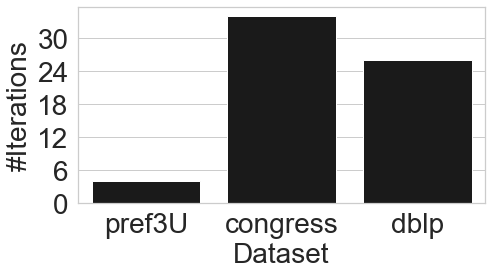

small_tau


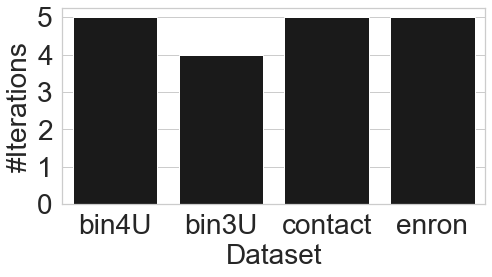

<Figure size 504x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.ticker import MaxNLocator
# ax.yaxis.set_major_locator(MaxNLocator(6)) 
# sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='large')
# plt.rc('ytick', labelsize='large')

# fontsize = 24
# labelsize = 20

# save = False 


order=["Local-Core"]
include_algos = ['opt_local_core']
# ['NBR', 'NBR(1)', 'NBR1s', 'NBR(2)',"pNBR(2)","pNBR(3)"]
group_list = ['dataset']
include_datasets = ['pref','congress','dblp']
# # columns = ['execution time']

working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'tau' 
 

ax = sns.barplot(x='dataset', y=y_axis, data=working_df, color='k', order = include_datasets)
ax.yaxis.set_major_locator(MaxNLocator(6)) 
# plt.xlabel('Dataset')
# plt.ylabel(good_name[y_axis])
# plt.legend()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
# plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.title()
# plt.legend(loc = 'best', fontsize=fontsize)
plt.tight_layout()
filename = ("large " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("results_final/fig/" + filename + ".pdf")
else:
    print(filename)
    plt.show()
plt.clf()


include_datasets = ['bin_2','bin_5','contact','enron']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'tau' 
 

sns.barplot(x='dataset', y=y_axis, data=working_df, color='k', order = include_datasets)
# plt.xlabel('Dataset')
# plt.ylabel(good_name[y_axis])
# plt.legend()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
# plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.title()
# plt.legend(loc = 'best', fontsize=fontsize)
plt.tight_layout()
filename = ("small " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("results_final/fig/" + filename + ".pdf")
else:
    print(filename)
    plt.show()
plt.clf()

Convergence (Core-correction Volume)
-------

large_sum_core_correction_volume


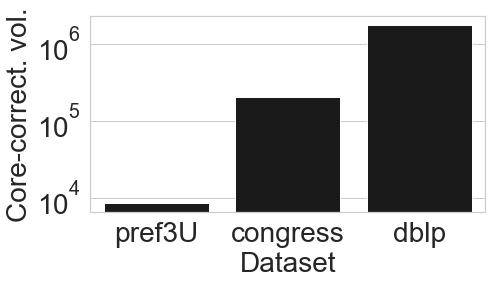

small_sum_core_correction_volume


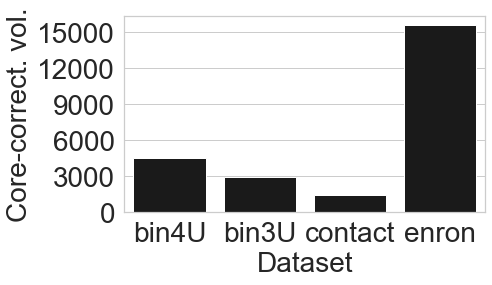

<Figure size 504x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.ticker import MaxNLocator
# ax.yaxis.set_major_locator(MaxNLocator(6)) 
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})

# save = True


good_name = {
    'bucket update time' : 'Bucket time (s)', 
    'execution time' : "Time (s)", 
    'neighborhood call time' : "NB time (s)", 
    'subgraph computation time' : "Sub time(s)",
    'num bucket update' : "#bucket", 
    'num neighborhood computation' : "#nb",
    'num subgraph call' : "#subgraph",
    'outerloop time': "outloop time(s)",
    'init time': 'init time(s)',
    'total iteration': '#total iterations',
    'inner iteration': '#inner iterations',
    'memory taken': 'Memory (MB)',
    'core_correction time': 'Core-corection time(s)',
    'h_index_time': 'h-index time(s)',
    'sum_core_correction_volume' : 'Core-correct. vol.',
    'tau': r'#Iterations (${\tau}$)'
    # 'num_threads' : '#Threads'
}

order=["Local-Core"]
include_algos = ['opt_local_core']
# ['NBR', 'NBR(1)', 'NBR1s', 'NBR(2)',"pNBR(2)","pNBR(3)"]
group_list = ['dataset']
include_datasets = ['pref','congress','dblp']
# # columns = ['execution time']

working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'sum_core_correction_volume' 
 

sns.barplot(x='dataset', y=y_axis, data=working_df, color='k', order = include_datasets)
# plt.xlabel('Dataset')
# plt.ylabel(good_name[y_axis])
# plt.legend()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.title()
# plt.legend(loc = 'best', fontsize=fontsize)
plt.tight_layout()
filename = ("large " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("results_final/fig/" + filename + ".pdf")
else:
    print(filename)
    plt.show()
plt.clf()


include_datasets = ['bin_2','bin_5','contact','enron']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'sum_core_correction_volume' 
 

ax = sns.barplot(x='dataset', y=y_axis, data=working_df, color='k', order = include_datasets)
ax.yaxis.set_major_locator(MaxNLocator(6)) 
# plt.xlabel('Dataset')
# plt.ylabel(good_name[y_axis])
# plt.legend()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
# plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.title()
# plt.legend(loc = 'best', fontsize=fontsize)
plt.tight_layout()
filename = ("small " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("results_final/fig/" + filename + ".pdf")
else:
    print(filename)
    plt.show()
plt.clf()

`Total discrepency between N(u) and c(u)`

In [ ]:
output_folder2 = '/Users/nus/hg-core-decomposition/data/output/server/'
# output_folder2 = '/Users/nus/hg-core-decomposition/run_par/mpi/data/output/'
df6 = pd.read_csv(output_folder2+"result_analysis.csv", header = None)
df6.columns = ['algo', 'core', 'core_correction_volume', 'dataset', 'execution time', 'init_nbrsize', 'reduction_in_hhat', 'sum_core_correction_volume', 'tau']
print(df6.head())

             algo  ...  tau
0  opt_local_core  ...  2.0
1  opt_local_core  ...  3.0
2  opt_local_core  ...  5.0
3  opt_local_core  ...  5.0
4  opt_local_core  ...  4.0

[5 rows x 9 columns]


In [ ]:
_dd = {'dataset': [], 'N(u)-c(u)':[]}
for key, row in df6[['dataset','core','init_nbrsize']].iterrows():
    sum = 0
    core = literal_eval(row['core'])
    nbr_len = literal_eval(row['init_nbrsize'])
    for k in core:
        sum += (nbr_len[k]-core[k])
    _dd['N(u)-c(u)'].append(sum)
    _dd['dataset'].append(row['dataset'])
print(_dd)

{'dataset': ['bin_1', 'bin_4', 'bin_2', 'enron', 'bin_5', 'contact', 'congress', 'pref', 'dblp', 'weeplaces', 'gowalla'], 'N(u)-c(u)': [1224, 895, 19646, 55604, 14080, 6511, 480364, 282378, 7766888, 6828553, 603792258]}


In [ ]:
df7 = pd.DataFrame.from_dict(_dd)
df7.head()

,dataset,N(u)-c(u)
0,bin_1,1224
1,bin_4,895
2,bin_2,19646
3,enron,55604
4,bin_5,14080


large_N(u)-c(u)


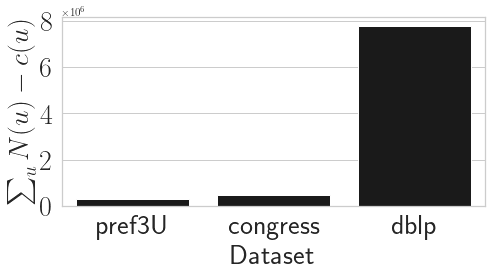

small_N(u)-c(u)


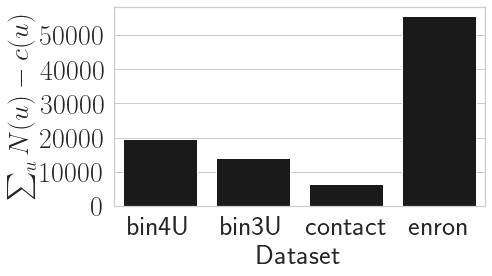

<Figure size 504x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
plt.rcParams['text.usetex'] = True
import seaborn as sns 
from matplotlib.ticker import MaxNLocator
# ax.yaxis.set_major_locator(MaxNLocator(6)) 
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})

save = False


good_name = {
    'bucket update time' : 'Bucket time (s)', 
    'execution time' : "Time (s)", 
    'neighborhood call time' : "NB time (s)", 
    'subgraph computation time' : "Sub time(s)",
    'num bucket update' : "#bucket", 
    'num neighborhood computation' : "#nb",
    'num subgraph call' : "#subgraph",
    'outerloop time': "outloop time(s)",
    'init time': 'init time(s)',
    'total iteration': '#total iterations',
    'inner iteration': '#inner iterations',
    'memory taken': 'Memory (MB)',
    'core_correction time': 'Core-corection time(s)',
    'h_index_time': 'h-index time(s)',
    'sum_core_correction_volume' : 'Core-correct. vol.',
    'tau': r'#Iterations (${\tau}$)',
    'N(u)-c(u)': '$\sum_{u} N(u)-c(u)$'
}

order=["Local-Core"]
include_algos = ['opt_local_core']
# ['NBR', 'NBR(1)', 'NBR1s', 'NBR(2)',"pNBR(2)","pNBR(3)"]
group_list = ['dataset']
include_datasets = ['pref','congress','dblp']
# # columns = ['execution time']

working_df = df7[df7['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'N(u)-c(u)'
 

sns.barplot(x='dataset', y=y_axis, data=working_df, color='k', order = include_datasets)
# plt.xlabel('Dataset')
# plt.ylabel(good_name[y_axis])
# plt.legend()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
# plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.title()
# plt.legend(loc = 'best', fontsize=fontsize)
plt.tight_layout()
filename = ("large " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("results_final/fig/" + filename + ".pdf")
else:
    print(filename)
    plt.show()
plt.clf()


include_datasets = ['bin_2','bin_5','contact','enron']
working_df =df7[df7['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'N(u)-c(u)'
 

ax = sns.barplot(x='dataset', y=y_axis, data=working_df, color='k', order = include_datasets)
ax.yaxis.set_major_locator(MaxNLocator(6)) 
# plt.xlabel('Dataset')
# plt.ylabel(good_name[y_axis])
# plt.legend()
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
# plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.title()
# plt.legend(loc = 'best', fontsize=fontsize)
plt.tight_layout()
filename = ("small " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("results_final/fig/" + filename + ".pdf")
else:
    print(filename)
    plt.show()
plt.clf()

Convergence
-------

`Core-correction vol vs Exectime`

['congress' 'dblp' 'pref3U']
small_N(u)-c(u)


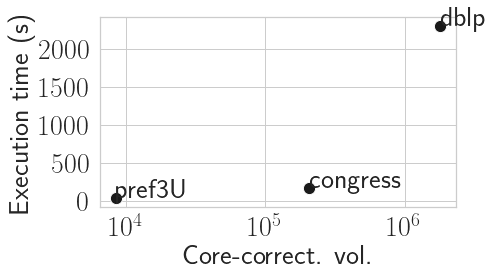

['bin3U' 'bin4U' 'contact' 'enron']
small_N(u)-c(u)


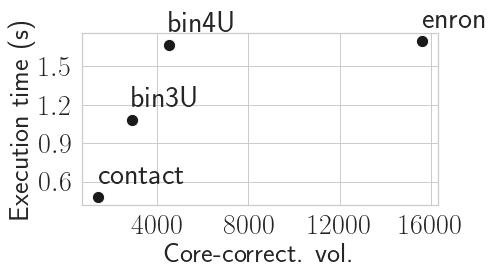

<Figure size 504x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.ticker import MaxNLocator

sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})


save = False 


good_name = {
    'bucket update time' : 'Bucket time (s)', 
    'execution time' : "Execution time (s)", 
    'neighborhood call time' : "NB time (s)", 
    'subgraph computation time' : "Sub time(s)",
    'num bucket update' : "#bucket", 
    'num neighborhood computation' : "#nb",
    'num subgraph call' : "#subgraph",
    'outerloop time': "outloop time(s)",
    'init time': 'init time(s)',
    'total iteration': '#total iterations',
    'inner iteration': '#inner iterations',
    'memory taken': 'Memory (MB)',
    'core_correction time': 'Core-corection time(s)',
    'h_index_time': 'h-index time(s)',
    'sum_core_correction_volume' : 'Core-correct. vol.',
    'tau': r'#Iterations (${\tau}$)'
    # 'num_threads' : '#Threads'
}

# NBR(1) adopts Arijits simplification to Bishwa's simplification.
good_name_algo = {
    'naive_nbr' : "Peel", 
    'improved_nbr_simple': "E-Peel", 
    'recursive_local_core': "LOCAL(r)",
    'iterative_local_core': "LOCAL(i)",
    'bst_local_core': "LOCAL(b)",
    'improved_local_core': "LOCAL(im)",
    'opt_local_core': "Local-core",
    'par_local_core': "LOCAL(p)",
    'improved2_nbr' : "NBR(2)",
    'par_improved2_nbr' : "pNBR(2)",
    'par_improved3_nbr' : "pNBR(3)",
    'naive_degree' : "DEG"
}

# order=['Peel', 'E-Peel', 'LOCAL', 'LOCAL(i)','LOCAL(b)']
order=["Local-Core"]
include_algos = ['opt_local_core']
# ['NBR', 'NBR(1)', 'NBR1s', 'NBR(2)',"pNBR(2)","pNBR(3)"]
group_list = ['dataset']

include_datasets = ['pref','congress','dblp']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
x_axis = 'sum_core_correction_volume' 
y_axis = 'execution time'

xlabels = working_df.groupby('dataset')[x_axis].mean().index.values
_em = working_df.groupby('dataset')[y_axis].mean()
_cm = working_df.groupby('dataset')[x_axis].mean()
exec_mean = [] 
cv_mean = [] 
# print(_em)
# print(_cm)
for key in xlabels:
    # print(key, _em.loc[key],_cm.loc[key])
    exec_mean.append(_em.loc[key])
    cv_mean.append(_cm.loc[key])

print(xlabels)
ax = sns.scatterplot(x = cv_mean, y = exec_mean,  marker='o', color = 'k', s = scatterplotBall)
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel(good_name[x_axis], fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

i = 0
for x,y in zip(cv_mean, exec_mean):
    plt.text(x+0.01, y+0.1, xlabels[i], fontsize=fontsize)
    i+=1
# plt.legend(loc = 'best', fontsize=fontsize)
plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
if(save):
    plt.savefig("results_final/fig/large_localcore_exec.pdf")
else:
    print(filename)
    plt.show()
plt.clf()


include_datasets = ['bin_2','bin_5','contact','enron']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
x_axis = 'sum_core_correction_volume' 
y_axis = 'execution time'

xlabels = working_df.groupby('dataset')[x_axis].mean().index.values
_em = working_df.groupby('dataset')[y_axis].mean()
_cm = working_df.groupby('dataset')[x_axis].mean()
exec_mean = [] 
cv_mean = [] 
# print(_em)
# print(_cm)
for key in xlabels:
    # print(key, _em.loc[key],_cm.loc[key])
    exec_mean.append(_em.loc[key])
    cv_mean.append(_cm.loc[key])

print(xlabels)
ax = sns.scatterplot(x = cv_mean, y = exec_mean,  marker='o', color = 'k', s = scatterplotBall)
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel(good_name[x_axis], fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

i = 0
for x,y in zip(cv_mean, exec_mean):
    plt.text(x+0.01, y+0.1, xlabels[i], fontsize=fontsize+2)
    i+=1
# plt.legend(loc = 'best', fontsize=fontsize)
# plt.xscale("log")
ax.xaxis.set_major_locator(MaxNLocator(5)) 
ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
if(save):
    plt.savefig("results_final/fig/small_localcore_exec.pdf")
else:
    print(filename)
    plt.show()
plt.clf()

` N(u) - c(u) vs Execution time`

small_N(u)-c(u)


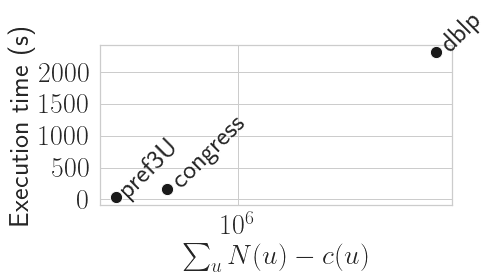

small_N(u)-c(u)


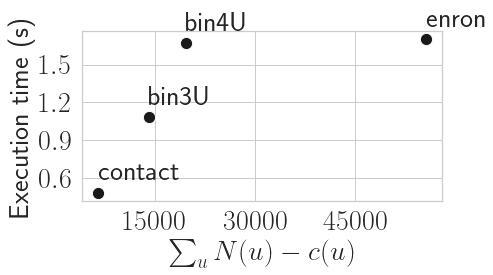

<Figure size 504x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.ticker import MaxNLocator

sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})


save = False 


good_name = {
    'bucket update time' : 'Bucket time (s)', 
    'execution time' : "Execution time (s)", 
    'neighborhood call time' : "NB time (s)", 
    'subgraph computation time' : "Sub time(s)",
    'num bucket update' : "#bucket", 
    'num neighborhood computation' : "#nb",
    'num subgraph call' : "#subgraph",
    'outerloop time': "outloop time(s)",
    'init time': 'init time(s)',
    'total iteration': '#total iterations',
    'inner iteration': '#inner iterations',
    'memory taken': 'Memory (MB)',
    'core_correction time': 'Core-corection time(s)',
    'h_index_time': 'h-index time(s)',
    'sum_core_correction_volume' : 'Core-correct. vol.',
    'tau': r'#Iterations (${\tau}$)',
    'N(u)-c(u)': '$\sum_{u} N(u)-c(u)$'
}

# order=['Peel', 'E-Peel', 'LOCAL', 'LOCAL(i)','LOCAL(b)']
order=["Local-Core"]
include_algos = ['opt_local_core']
# ['NBR', 'NBR(1)', 'NBR1s', 'NBR(2)',"pNBR(2)","pNBR(3)"]
group_list = ['dataset']

include_datasets = ['pref','congress','dblp']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
newdf = pd.merge(working_df,df7,on='dataset')
newdf = newdf.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
x_axis =  'N(u)-c(u)'
y_axis = 'execution time'

_em = newdf.groupby('dataset')[y_axis].mean()
_cm = newdf.groupby('dataset')[x_axis].mean()
ylabels = newdf.groupby('dataset')[y_axis].mean().index.values
exec_mean = [] 
discrepency = [] 
for key in ylabels:
    exec_mean.append(_em.loc[key])
    discrepency.append(_cm.loc[key])

# print(ylabels)
# print(exec_mean)
# print(discrepency)

ax = sns.scatterplot(x = discrepency, y = exec_mean,  marker='o', color = 'k', s = scatterplotBall)
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel(good_name[x_axis], fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

i = 0
for x,y in zip(discrepency, exec_mean):
    plt.text(x+0.01, y+0.2, ylabels[i], fontsize=fontsize, rotation = 45)
    i+=1
# plt.legend(loc = 'best', fontsize=fontsize)
plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
if(save):
    plt.savefig("results_final/fig/large_localcore_exec2.pdf")
else:
    print(filename)
    plt.show()
plt.clf()


include_datasets = ['bin_2','bin_5','contact','enron']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df.replace({"algo": good_name_algo})
newdf = pd.merge(working_df,df7,on='dataset')
newdf = newdf.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
x_axis =  'N(u)-c(u)'
y_axis = 'execution time'

_em = newdf.groupby('dataset')[y_axis].mean()
_cm = newdf.groupby('dataset')[x_axis].mean()
ylabels = newdf.groupby('dataset')[y_axis].mean().index.values
exec_mean = [] 
discrepency = [] 
for key in ylabels:
    exec_mean.append(_em.loc[key])
    discrepency.append(_cm.loc[key])

ax = sns.scatterplot(x = discrepency, y = exec_mean,  marker='o', color = 'k', s = scatterplotBall)
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel(good_name[x_axis], fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

i = 0
for x,y in zip(discrepency, exec_mean):
    plt.text(x+0.01, y+0.1, ylabels[i], fontsize=fontsize)
    i+=1

# i = 0
# for x,y in zip(cv_mean, exec_mean):
#     plt.text(x+0.01, y+0.1, xlabels[i], fontsize=fontsize+2)
#     i+=1
# plt.legend(loc = 'best', fontsize=fontsize)
# plt.xscale("log")
ax.xaxis.set_major_locator(MaxNLocator(5)) 
ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
if(save):
    plt.savefig("results_final/fig/small_localcore_exec2.pdf")
else:
    print(filename)
    plt.show()
plt.clf()

In [ ]:
# import matplotlib.pyplot as plt 
# # import seaborn as sns 
# # sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# # plt.rc('font', family='serif')
# # plt.rc('xtick', labelsize='large')
# # plt.rc('ytick', labelsize='large')

# # fontsize = 24
# # labelsize = 20

# save = False 



# # columns = ['bucket update time', 'execution time', 'init time', 'inner iteration', 'memory taken', 'neighborhood call time', 'num bucket update', 'num neighborhood computation', 'num subgraph call', 'outerloop time',  'subgraph computation time', 'total iteration']
# # columns = ['execution time','Sum Core-correction vol', 'tau', 'h_index_time','core_correction time','memory taken','init time','outerloop time']
# # columns = ['execution time','sum_core_correction_volume', 'tau']
# good_name = {
#     'bucket update time' : 'Bucket time (s)', 
#     'execution time' : "Time (s)", 
#     'neighborhood call time' : "NB time (s)", 
#     'subgraph computation time' : "Sub time(s)",
#     'num bucket update' : "#bucket", 
#     'num neighborhood computation' : "#nb",
#     'num subgraph call' : "#subgraph",
#     'outerloop time': "outloop time(s)",
#     'init time': 'init time(s)',
#     'total iteration': '#total iterations',
#     'inner iteration': '#inner iterations',
#     'memory taken': 'Memory (MB)',
#     'core_correction time': 'Core-corection time(s)',
#     'h_index_time': 'h-index time(s)',
#     'sum_core_correction_volume' : 'Core-correct. vol.',
#     'tau': r'#Iterations (${\tau}$)'
#     # 'num_threads' : '#Threads'
# }

# # order=['Peel', 'E-Peel', 'LOCAL', 'LOCAL(i)','LOCAL(b)']
# order=["Local-Core"]
# include_algos = ['opt_local_core']

# y_axis = 'sum_core_correction_volume' 
# x_axis = 'execution time'
# include_datasets = ['contact','enron','pref','congress','dblp']
# # sns.scatterplot(x=x_axis, y=y_axis, data=df, color='k', hue = 'dataset',hue_order=include_datasets)
# # plt.show()

# # include_datasets = ['pref','congress','dblp']
# # # columns = ['execution time']



# # working_df = df[df['dataset'].isin(include_datasets)].copy()
# # working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# # working_df = working_df.replace({"algo": good_name_algo})
# # working_df = working_df.replace({"dataset": good_name_dataset})
# # include_datasets = [good_name_dataset[d] for d in include_datasets]
# # y_axis = 'sum_core_correction_volume' 
# # x_axis = 'execution time'

# # # print(working_df.groupby('dataset')[x_axis].mean())
# # sns.lineplot(x=x_axis, y=y_axis, data=working_df, color='k', hue = 'dataset',hue_order=include_datasets)
# # # plt.xlabel('Dataset')
# # # plt.ylabel(good_name[y_axis])
# # # plt.legend()
# # plt.xlabel(good_name[x_axis], fontsize=fontsize)
# # plt.ylabel(good_name[y_axis], fontsize=fontsize)
# # plt.yscale("log")
# # plt.xticks(fontsize=fontsize)
# # plt.yticks(fontsize=fontsize)
# # # plt.title()
# # plt.legend(loc = 'lower right', fontsize=fontsize)
# # plt.tight_layout()
# # filename = ("large "+x_axis + y_axis).replace(" ", "_")
# # if(save):
# #     plt.savefig("results_final/fig/" + filename + ".pdf")
# # else:
# #     print(filename)
# #     plt.show()
# # plt.clf()


# # include_datasets = ['bin_2','bin_5','contact','enron']
# # working_df = df[df['dataset'].isin(include_datasets)].copy()
# # working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# # working_df = working_df.replace({"algo": good_name_algo})
# # working_df = working_df.replace({"dataset": good_name_dataset})
# # include_datasets = [good_name_dataset[d] for d in include_datasets]
# # # y_axis = 'sum_core_correction_volume' 
 

# # sns.scatterplot(x=x_axis, y=y_axis, data=working_df, color='k', hue = 'dataset',hue_order=include_datasets)
# # # sns.barplot(x=x_axis, y=y_axis, data=working_df, color='k', order = include_datasets)
# # # plt.xlabel('Dataset')
# # # plt.ylabel(good_name[y_axis])
# # # plt.legend()
# # plt.xlabel(good_name[x_axis], fontsize=fontsize)
# # plt.ylabel(good_name[y_axis], fontsize=fontsize)
# # plt.yscale("log")
# # plt.xticks(fontsize=fontsize)
# # plt.yticks(fontsize=fontsize)
# # # plt.title()
# # plt.legend(loc = 'best', fontsize=fontsize, title = None)
# # plt.tight_layout()
# # filename = ("small "+x_axis + y_axis).replace(" ", "_")
# # if(save):
# #     plt.savefig("results_final/fig/" + filename + ".pdf")
# # else:
# #     print(filename)
# #     plt.show()
# # plt.clf()

reduction in hhat
-----

In [ ]:
# import matplotlib.pyplot as plt 

# # import seaborn as sns 
# # sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# # plt.rc('font', family='serif')
# # plt.rc('xtick', labelsize='large')
# # plt.rc('ytick', labelsize='large')

# # fontsize = 24
# # labelsize = 20

# save = False 

# # # interests = ['core_correction time', 'core_correction_volume','h_index_time','reduction_in_hhat', 'sum_core_correction_volume', 'tau']
# # sns.set(rc={'figure.figsize':(7,5)})
# # sns.set_style("whitegrid", {'axes.grid' : True})

# # columns = ['bucket update time', 'execution time', 'init time', 'inner iteration', 'memory taken', 'neighborhood call time', 'num bucket update', 'num neighborhood computation', 'num subgraph call', 'outerloop time',  'subgraph computation time', 'total iteration']
# # columns = ['execution time','Sum Core-correction vol', 'tau', 'h_index_time','core_correction time','memory taken','init time','outerloop time']
# # columns = ['execution time','sum_core_correction_volume', 'tau']
# good_name = {
#     'bucket update time' : 'Bucket time (s)', 
#     'execution time' : "Time (s)", 
#     'neighborhood call time' : "NB time (s)", 
#     'subgraph computation time' : "Sub time(s)",
#     'num bucket update' : "#bucket", 
#     'num neighborhood computation' : "#nb",
#     'num subgraph call' : "#subgraph",
#     'outerloop time': "outloop time(s)",
#     'init time': 'init time(s)',
#     'total iteration': '#total iterations',
#     'inner iteration': '#inner iterations',
#     'memory taken': 'Memory (MB)',
#     'core_correction time': 'Core-corection time(s)',
#     'h_index_time': 'h-index time(s)',
#     'sum_core_correction_volume' : 'Core-correct. vol.',
#     'tau': r'#Iterations (${\tau}$)',
#     "reduction_in_hhat": r'${\sum_{i = 1}^{|V|} \hat{h}_i^{(n)} - \hat{h}_i^{(n-1)}}$'
#     # 'num_threads' : '#Threads'
# }

# # NBR(1) adopts Arijits simplification to Bishwa's simplification.
# good_name_algo = {
#     'naive_nbr' : "Peel", 
#     'improved_nbr_simple': "E-Peel", 
#     'recursive_local_core': "LOCAL(r)",
#     'iterative_local_core': "LOCAL(i)",
#     'bst_local_core': "LOCAL(b)",
#     'improved_local_core': "LOCAL(im)",
#     'opt_local_core': "Local-Core",
#     'par_local_core': "LOCAL(p)",
#     'improved2_nbr' : "NBR(2)",
#     'par_improved2_nbr' : "pNBR(2)",
#     'par_improved3_nbr' : "pNBR(3)",
#     'naive_degree' : "DEG"
# }

# # order=['Peel', 'E-Peel', 'LOCAL', 'LOCAL(i)','LOCAL(b)']
# order=["Local-Core"]
# include_algos = ['opt_local_core']
# # ['NBR', 'NBR(1)', 'NBR1s', 'NBR(2)',"pNBR(2)","pNBR(3)"]
# group_list = ['dataset']
# include_datasets = ['pref','congress']
# # # columns = ['execution time']

# working_df = df[df['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df = working_df.replace({"algo": good_name_algo})
# working_df = working_df.replace({"dataset": good_name_dataset})
# include_datasets = [good_name_dataset[d] for d in include_datasets]
# y_axis = 'reduction_in_hhat' 
 
# for key, item in working_df.groupby('dataset', as_index=False):
#     # print(key)
#     first_reduction_values = literal_eval(item.iloc[0][y_axis]) 
#     n = range(1,len(first_reduction_values)+1)
#     # y = np.log(first_reduction_values[:-1]).tolist()+[0]
#     # plt.plot(n, y, label = key)
#     plt.plot(n, first_reduction_values, label = key)
#     # plt.loglog(n, first_reduction_values, label = key)

# plt.xlabel('n')
# plt.ylabel(good_name[y_axis])
# # plt.yscale('log')
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.legend(loc = 'best', fontsize=fontsize)
# plt.tight_layout()
# filename = ("large " + y_axis).replace(" ", "_")
# if(save):
#     plt.savefig("results_final/fig/" + filename + ".pdf")
# else:
#     print(filename)
#     plt.show()
# plt.clf()



# include_datasets = ['bin_2','bin_5','contact','enron']
# working_df = df[df['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df = working_df.replace({"algo": good_name_algo})
# working_df = working_df.replace({"dataset": good_name_dataset})
# include_datasets = [good_name_dataset[d] for d in include_datasets]
# y_axis = 'reduction_in_hhat' 
 
# _max_n = -1000
# for key, item in working_df.groupby('dataset', as_index=False):
#     # print(key)
#     first_reduction_values = literal_eval(item.iloc[0][y_axis]) 
#     n = range(1,len(first_reduction_values)+1)
#     _max_n = max(_max_n, n[-1])
#     # y = np.log(first_reduction_values[:-1]).tolist()+[0]
#     # plt.plot(n, y, label = key)
#     plt.plot(n, first_reduction_values, label = key)
#     # plt.loglog(n, first_reduction_values, label = key)

# plt.xlabel('n')
# plt.ylabel(good_name[y_axis])
# # plt.yscale('log')
# plt.xticks(range(1,_max_n +1), fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.legend(loc = 'best', fontsize=fontsize)


# plt.tight_layout()
# filename = ("small " + y_axis).replace(" ", "_")
# if(save):
#     plt.savefig("results_final/fig/" + filename + ".pdf")
# else:
#     print(filename)
#     plt.show()
# plt.clf()

Local-core vs Epeel.
-----------

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
import pandas as pd
import seaborn as sns
import numpy as np
import os
from ast import literal_eval
import shutil
# from matplotlib import pyplot as plt 

labelsize = 28
fontsize = 32 

plt.rc('xtick', labelsize= labelsize)
plt.rc('ytick', labelsize= labelsize)

e_peel_time = {
    'enron' : 0.377735, 
    "dblp" : 97.4
}

goodname_accuracy = {
    # 'element_wise_matching' : 'Per vertex matching', 
    # 'element_wise_matching' : 'Frac. of correct core-number', 
    'element_wise_matching' : '%Correct core-num', 
    # 'accumulated_per_vertex_accuracy' : 'Per vertex accuracy',
    # 'accumulated_per_vertex_accuracy' : 'Mean accuracy',
    'accumulated_per_vertex_accuracy' : 'Mean approx. error',
    'accumulated_accuracy' : 'Accumulated accuracy',
    "mean_approx_error": "Mean approx. error"
}


def mean_approx_error(current_core, best_core):
    per_vertex_error = 0
    for k in current_core:
        per_vertex_error += float((abs(current_core[k] - best_core[k])) / best_core[k])
    return float(per_vertex_error / len(best_core)) 

def element_wise_matching(current_core, best_core):
    correct_matching = 0
    for k in current_core:
        if(current_core[k] == best_core[k]):
            correct_matching += 1
    return float(correct_matching / len(best_core))
    
def get_corenumIntersect(df, xi):
    y2 = df["element_wise_matching"].values[1]*100
    x2 = df['execution time'].values[1]
    y1 = df["element_wise_matching"].values[0]*100
    x1 = df['execution time'].values[0]
    slope_line1 = (y2-y1)/(x2-x1)
    intercept1 = y1 - slope_line1*x1

    # xi = e_peel_time[dataset]
    yi = slope_line1*xi + intercept1
    return xi, yi

def get_approxIntersect(df, xi):
    y2 = df["mean_approx_error"].values[1]
    x2 = df['execution time'].values[1]
    y1 = df["mean_approx_error"].values[0]
    x1 = df['execution time'].values[0]
    slope_line1 = (y2-y1)/(x2-x1)
    intercept1 = y1 - slope_line1*x1

    # xi = e_peel_time[dataset]
    yi = slope_line1*xi + intercept1
    return xi, yi

SyntaxError: invalid syntax (<ipython-input-125-31a1d92f6718>, line 32)

In [ ]:
save = True 
lw = 4
dataset = "dblp"
df = pd.read_csv('results_final/' + dataset + "_local_core.csv", header=None)
df.columns = ['algo', 'core', 'dataset', 'execution time', 'iteration', 'num_threads', 'outer iteration']
print(df.shape)
df['core'] = df.apply(lambda x: literal_eval(x['core']), axis = 1)
best_index = df['iteration'].argmax() # last iteration is the best (actual) value of core
best_core = df.iloc[best_index]['core']
print(best_index)
df['element_wise_matching'] = df.apply(lambda x: element_wise_matching(x['core'], best_core), axis=1)
df["mean_approx_error"] = df.apply(lambda x: mean_approx_error(x['core'], best_core), axis=1)

fig, ax = plt.subplots(figsize=(9, 6))
twin1 = ax.twinx()
y = 'element_wise_matching' 
x = 'execution time'
# color = 'tab:red'
color = 'k'
ax.set_xlabel('Execution time (s)', fontsize = fontsize)
ax.set_ylabel(goodname_accuracy[y], color=color, fontsize = fontsize)
p1, = ax.plot(df[x].values, df[y].values*100, color=color, label = 'Local-core (%correct)', marker = 'o', linewidth = lw)

# x2,y2 = get_corenumIntersect(df, e_peel_time[dataset])
# x1,y1 = (0,y2) 
# p4 = ax.plot( (x1,x2),  (y1,y2), linestyle='dashed')
if dataset == 'dblp':
    xi, yi = get_corenumIntersect(df, e_peel_time[dataset])
    p4 = ax.axhline(y = yi, xmax = 0.088, linestyle='dashed', color = color)
if dataset == 'enron':
    xi, yi = get_corenumIntersect(df, e_peel_time[dataset])
    p4 = ax.axhline(y = yi, xmax = 0.255, linestyle='dashed',color = color)

ax.tick_params(axis='y', labelcolor=color)

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

y = 'mean_approx_error' 
color = 'b'
twin1.set_ylabel(goodname_accuracy[y], color=color, fontsize= fontsize)
p2, = twin1.plot(df[x].values, df[y].values, color=color, label = 'Local-core (error)', marker = '*', linewidth = lw)
twin1.tick_params(axis='y', labelcolor=color)

p3 = twin1.axvline(e_peel_time[dataset], label="E-Peel", color='C1', linestyle='dashed', linewidth = lw)
if dataset == 'dblp':
    xi, yi = get_approxIntersect(df, e_peel_time[dataset])
    p5 = twin1.axhline(y = yi, xmin = 0.085, linestyle='dashed',color = color)

if dataset == 'enron':
    xi, yi = get_approxIntersect(df, e_peel_time[dataset])
    p5 = twin1.axhline(y = yi, xmin = 0.255, linestyle='dashed',color = color)

if dataset == 'enron':
    ax.legend(handles=[p1, p2, p3], loc = 'upper right', fontsize = fontsize-2)
if dataset == 'dblp':
    ax.legend(handles=[p1, p2, p3], loc = 'center right', fontsize = fontsize-2)
plt.tight_layout()
filename = dataset+"_localanalysis"
if(save):
    plt.savefig("results_final/fig/" + filename + "_combined3.pdf")
else:
    print(filename)
    plt.show()
plt.clf()

(27, 7)
26


<Figure size 648x432 with 0 Axes>

In [ ]:
save = True 

labelsize = 28
fontsize = 32 

lw = 4
dataset = "enron"
df = pd.read_csv('results_final/' + dataset + "_local_core.csv", header=None)
df.columns = ['algo', 'core', 'dataset', 'execution time', 'iteration', 'num_threads', 'outer iteration']
print(df.shape)
df['core'] = df.apply(lambda x: literal_eval(x['core']), axis = 1)
best_index = df['iteration'].argmax() # last iteration is the best (actual) value of core
best_core = df.iloc[best_index]['core']
print(best_index)

df['element_wise_matching'] = df.apply(lambda x: element_wise_matching(x['core'], best_core), axis=1)
df["mean_approx_error"] = df.apply(lambda x: mean_approx_error(x['core'], best_core), axis=1)

fig, ax = plt.subplots(figsize=(9, 6))
twin1 = ax.twinx()

y = 'element_wise_matching' 
x = 'execution time'
# color = 'tab:red'
color = 'k'
ax.set_xlabel('Execution time (s)', fontsize = fontsize)
ax.set_ylabel(goodname_accuracy[y], color=color, fontsize = fontsize)
p1, = ax.plot(df[x].values, df[y].values*100, color=color, label = 'Local-core (%correct)', marker = 'o', linewidth = lw)

# x2,y2 = get_corenumIntersect(df, e_peel_time[dataset])
# x1,y1 = (0,y2) 
# p4 = ax.plot( (x1,x2),  (y1,y2), linestyle='dashed')
if dataset == 'dblp':
    xi, yi = get_corenumIntersect(df, e_peel_time[dataset])
    p4 = ax.axhline(y = yi, xmax = 0.088, linestyle='dashed', color = color)
if dataset == 'enron':
    xi, yi = get_corenumIntersect(df, e_peel_time[dataset])
    p4 = ax.axhline(y = yi, xmax = 0.255, linestyle='dashed',color = color)

ax.tick_params(axis='y', labelcolor=color)

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

y = 'mean_approx_error' 
color = 'b'
twin1.set_ylabel(goodname_accuracy[y], color=color, fontsize= fontsize)
p2, = twin1.plot(df[x].values, df[y].values, color=color, label = 'Local-core (error)', marker = '*', linewidth = lw)
twin1.tick_params(axis='y', labelcolor=color)

p3 = twin1.axvline(e_peel_time[dataset], label="E-Peel", color='C1', linestyle='dashed', linewidth = lw)
if dataset == 'dblp':
    xi, yi = get_approxIntersect(df, e_peel_time[dataset])
    p5 = twin1.axhline(y = yi, xmin = 0.085, linestyle='dashed',color = color)

if dataset == 'enron':
    xi, yi = get_approxIntersect(df, e_peel_time[dataset])
    p5 = twin1.axhline(y = yi, xmin = 0.255, linestyle='dashed',color = color)

if dataset == 'enron':
    ax.legend(handles=[p1, p2, p3], loc = 'upper right', fontsize = fontsize-2)
if dataset == 'dblp':
    ax.legend(handles=[p1, p2, p3], loc = 'center right', fontsize = fontsize-2)
plt.tight_layout()
filename = dataset+"_localanalysis"
if(save):
    plt.savefig("results_final/fig/" + filename + "_combined3.pdf")
else:
    print(filename)
    plt.show()
plt.clf()

(6, 7)
5


<Figure size 648x432 with 0 Axes>

Scalability result plot
----------

In [ ]:
scal_output = "/Users/nus/hg-core-decomposition/data/output/scal_result(2).csv"
scal_df = pd.read_csv(scal_output, header = None)
scal_df.columns = ['algo', 'bucket update time', 'core', 'core_correction time', 'core_correction_volume', 'dataset', 'degree call time', 'execution time', 'h_index_time', 'init time', 'inner iteration', 'memory taken', 'neighborhood call time', 'num bucket update', 'num degree computation', 'num neighborhood computation', 'num subgraph call', 'num_threads', 'outerloop time', 'param_s', 'reduction_in_hhat', 'subgraph computation time', 'sum_core_correction_volume', 'tau', 'total iteration']
print(scal_df.shape)
scal_df = scal_df[['algo','dataset','execution time']]

(300, 25)


In [ ]:
# scal_df.head(5)
scal_df.tail(5)

,algo,dataset,execution time
295,naive_nbr,pref_8,1170.674288
296,naive_nbr,pref_8,1083.750182
297,naive_nbr,pref_8,1059.232457
298,naive_nbr,pref_8,1058.960740
299,naive_nbr,pref_8,1063.176423


dblp_scalability_execution_time


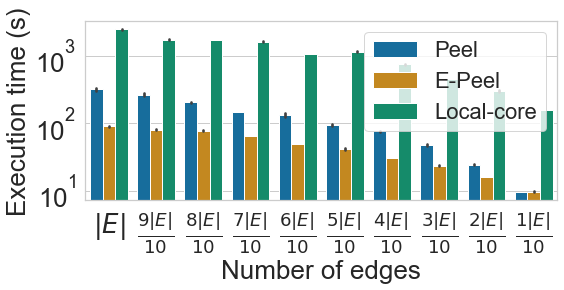

pref_scalability_execution_time


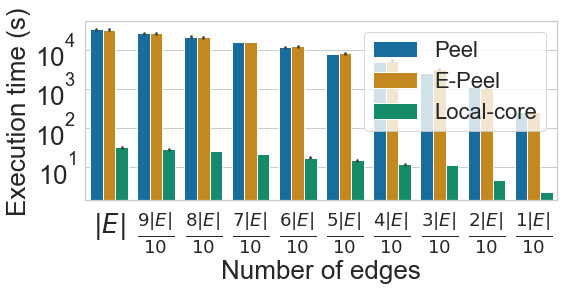

<Figure size 576x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid", {'axes.grid' : True})

save = False

# columns = ['bucket update time', 'execution time', 'init time', 'inner iteration', 'memory taken', 'neighborhood call time', 'num bucket update', 'num neighborhood computation', 'num subgraph call', 'outerloop time',  'subgraph computation time', 'total iteration']
# columns = ['execution time','Sum Core-correction vol', 'tau', 'h_index_time','core_correction time','memory taken','init time','outerloop time']
# columns = ['execution time','sum_core_correction_volume', 'tau']

# order=['Peel', 'E-Peel', 'LOCAL', 'LOCAL(i)','LOCAL(b)']
include_algos = ['naive_nbr','improved_nbr_simple','opt_local_core']
# ['NBR', 'NBR(1)', 'NBR1s', 'NBR(2)',"pNBR(2)","pNBR(3)"]
group_list = ['dataset']
data_prefix = ['dblp','pref']
for dp in data_prefix:
    include_datasets = [dp+'_' + str(i) for i in range(10)]
    num_edges = ['$|E|$']+['$\\frac{'+str(i)+"|E|}{10}$" for i in range(9,0,-1)]
    good_name_dataset = {dname: num_edges[j] for j, dname in enumerate(include_datasets)}
    # columns = ['execution time']

    working_df = scal_df[scal_df['dataset'].isin(include_datasets)].copy()
    working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    working_df = working_df.replace({"algo": good_name_algo})
    working_df = working_df.replace({"dataset": good_name_dataset})
    include_datasets = [good_name_dataset[d] for d in include_datasets]
    y_axis = 'execution time'  

    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())

    sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind', hue_order = order, order = include_datasets)
    plt.xlabel('Number of edges', fontsize=fontsize-2)
    plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
    plt.yscale("log")
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    # plt.title()
    plt.legend(loc = 'upper right', fontsize=fontsize-6)
    plt.tight_layout()
    filename = (dp+" scalability " + y_axis).replace(" ", "_")
    if(save):
        plt.savefig("results_final/fig/" + filename + ".pdf")
    else:
        print(filename)
        plt.show()
    plt.clf()

Pandemic propagation results
=================

In [540]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from ast import literal_eval
import shutil

output_folder = 'diffusion/output/'
# if os.path.exists(output_folder+"fig/"):
#     shutil.rmtree(output_folder+"fig/")
# os.mkdir(output_folder+"fig/")

# fontsize = 18
# labelsize = 12

In [542]:
df = pd.read_csv(output_folder + "/propagation_result.csv", header=None)
df.columns = ['dataset', 'p', 'algo', 'exp', 'result', 'timestep_results', 'intervention_results']
print(df.shape)
df.head(15)


(2, 7)


,dataset,p,algo,exp,result,timestep_results,intervention_results
0,enron,0.3,naive_nbr,sir,"{24: [3611, 3598, 3631, 3621, 3651, 3626, 3622...",NaN,NaN
1,enron,0.3,naive_nbr,sir_exp2,NaN,"{24: [3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3...",NaN


Infected Proportion
======

enron_03_propagation


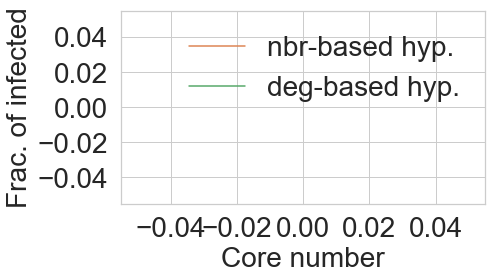

In [549]:
import seaborn as sns 
from matplotlib.ticker import MaxNLocator
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
lw = 3
save = False


ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact']
group_list = ['dataset', 'p']
goodname_algo = {
        'graph_core': 'clique graph',
        'naive_nbr': 'nbr-based hyp.',
        'naive_degree': 'deg-based hyp.'
    }

# group_list = ['algo',  'p']
for key, item in df[df['exp2'] == False].groupby(group_list, as_index=False):
    if item['dataset'].values[0] in ignore_datasets:
        continue


    item['algo'] = item['algo'].replace(goodname_algo)
    result_df = pd.DataFrame()
    for algo in item['algo'].unique():
        
        assert item[item['algo'] == algo].shape[0] == 1
        result = literal_eval(item[item['algo'] == algo]['result'].iloc[0])
        result = [(k, v, algo) for k in result for v in result[k]]
        result_df = result_df.append(pd.DataFrame(result, columns = ['core number', 'infected', 'algo']), ignore_index=False)
        

    #Plot mean
    meandf = result_df.groupby(['core number', 'algo']).mean().reset_index()
    fig, ax = plt.subplots()
    sns.lineplot(x = 'core number', y = 'infected', hue='algo', hue_order = ['clique graph', 'nbr-based hyp.', 'deg-based hyp.'], 
                    data=meandf, color='k', linewidth = lw)
    
    plt.xlabel('Core number', fontsize=fontsize)
    plt.ylabel("Frac. of infected", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    # plt.xticks()
    plt.yticks(fontsize=fontsize)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], fontsize=fontsize)
    # plt.title(key)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_major_locator(MaxNLocator(5)) 
    plt.tight_layout()
    filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
    if(save):
        plt.savefig("results_final/fig/" + filename + "_mean_all_algo.pdf")
    else:
        print(filename)
        plt.show()
        break
    plt.clf()

New plot for Infected proportion (only our algorithm)
------

In [546]:
import seaborn as sns 
from matplotlib.ticker import MaxNLocator
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
lw = 3
save = False


ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact']
include_algos = ['naive_nbr']

group_list = ['dataset', 'p']
goodname_algo = {
        'graph_core': 'clique graph',
        'naive_nbr': 'nbr-based hyp.',
        'naive_degree': 'deg-based hyp.'
    }
df = df[df['algo'].isin(include_algos)].copy()
# group_list = ['algo',  'p']
for key, item in df[df['exp2'] == False].groupby(group_list, as_index=False):
    if item['dataset'].values[0] in ignore_datasets:
        continue


    item['algo'] = item['algo'].replace(goodname_algo)
    result_df = pd.DataFrame()
    for algo in item['algo'].unique(): 
        assert item[item['algo'] == algo].shape[0] == 1
        result = literal_eval(item[item['algo'] == algo]['result'].iloc[0])
        result = [(k, v, algo) for k in result for v in result[k]]
        result_df = result_df.append(pd.DataFrame(result, columns = ['core number', 'infected', 'algo']), ignore_index=False)
        

    #Plot mean
    meandf = result_df.groupby(['core number', 'algo']).mean().reset_index()
    fig, ax = plt.subplots()
    # sns.lineplot(x = 'core number', y = 'infected', hue='algo', hue_order = ['clique graph', 'nbr-based hyp.', 'deg-based hyp.'], 
    #                 data=meandf, color='k', linewidth = lw)
    sns.lineplot(x = 'core number', y = 'infected', data=meandf, color='k', linewidth = lw)
    plt.xlabel('Core number', fontsize=fontsize)
    plt.ylabel("Frac. of infected", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    # plt.xticks()
    plt.yticks(fontsize=fontsize)
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles=handles[1:], labels=labels[1:], fontsize=fontsize)
    # plt.title(key)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_major_locator(MaxNLocator(5)) 
    plt.tight_layout()
    filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
    if(save):
        plt.savefig("results_final/fig/" + filename + "_mean_ours.pdf")
    else:
        print(filename)
        plt.show()
        break
    plt.clf()

KeyError: 'exp2'

First Infection time
=========

In [ ]:
import seaborn as sns 
from matplotlib.ticker import MaxNLocator
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
save = True

ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact']
only_algo = ['enron']
group_list = ['algo', 'dataset', 'p']
# group_list = ['algo',  'p']
for key, item in df[df['exp2'] == True].groupby(group_list, as_index=False):
    # there should be only one result
    assert item.shape[0] == 1
    if item['dataset'].values[0] in ignore_datasets:
        continue
    
    
    
    result = literal_eval(item['timestep_results'].iloc[0])
    result = [(k, v) for k in result for v in result[k]]
    result_df = pd.DataFrame(result, columns = ['core number', 'timestep of infection'])
    
    
    sns.lineplot(x = 'core number', y = 'timestep of infection',  data=result_df, color = 'k', linewidth = lw)
    plt.xlabel('Core number', fontsize=fontsize)
    plt.ylabel("First infection-time", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    # plt.xticks()
    plt.yticks(fontsize=fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5)) 
    # plt.title(goodname_algo[key[0]], fontsize=fontsize)
    plt.tight_layout()
    # TODO: 
    #  Add redline on the MAX_ITERATION
    filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
    if(save):
        plt.savefig("results_final/fig/" + filename + "_exp2.pdf")
    else:
        print(filename)
        plt.show()
        break
    plt.clf()

<Figure size 504x288 with 0 Axes>

Intervention strategy
-------

`Recursively delete innermost core vertices altogether`

In [241]:
# df = pd.read_csv(output_folder + "/propagation_result.csv", header=None)
df = pd.read_csv("data/output/propagation_result_recursive_delinner_enron.csv", header=None)
df.columns = ['dataset', 'p', 'algo', 'exp', 'result', 'timestep_results', 'intervention_results']
# df.columns = ['algo', 'dataset', 'exp', 'intervention_results', 'p', 'result', 'timestep_results']
print(df.shape)
df.head(15)

(2, 7)


,dataset,p,algo,exp,result,timestep_results,intervention_results
0,enron,0.3,naive_nbr,sir_exp3,NaN,NaN,"{0: {24: [3594, 3610, 3616, 3610, 3601, 3624, ..."
1,enron,0.3,naive_nbr,sir_exp3,NaN,NaN,"{0: {24: [3648, 3613, 3583, 3593, 3645, 3645, ..."


('default', 0.3)
dict_keys([0, 1])
  hypergraph  core number  infected
0         H0            1      2.35
1         H0            2      3.75
2         H0            6      6.55
3         H1            1      9.75
default_03_propagation


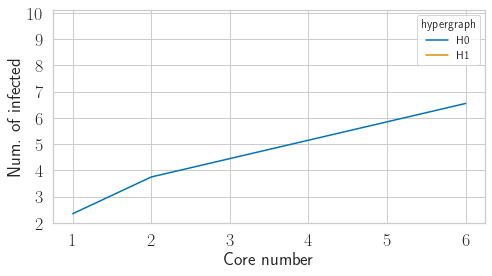

<Figure size 504x288 with 0 Axes>

In [240]:
import pandas as pd
import seaborn as sns 
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

fontsize = 18
labelsize = 12


# from matplotlib.ticker import MaxNLocator
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
lw = 3
save = False
output_folder = 'results_final/'
topk = 5 

ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact','default']
group_list = ['dataset', 'p']
goodname_algo = {
        'graph_core': 'clique graph',
        'naive_nbr': 'nbr-based hyp.',
        'naive_degree': 'deg-based hyp.'
    }

# df = pd.read_csv(os.path.join("data/output/propagation_result_topk_exp3.csv"), header=None)
# df.columns = ['dataset', 'p', 'algo', 'exp', 'result', 'timestep_results', 'intervention_results']
# print(df.shape)
# print(df.head(10))
for key, item in df[df['intervention_results'].notnull()].groupby(group_list, as_index=False):
    print(key)
    # if item['dataset'].values[0] in ignore_datasets:
    #     continue

    item['algo'] = item['algo'].replace(goodname_algo)
    assert len(item['algo'].unique()) == 1
    
    result = literal_eval(item['intervention_results'].iloc[0])
    print(result.keys())
    # print(result['top5'].keys())
    # print(len(result['top5'][1]))
    # for top_val in ['top5', 'top10', 'top15']:
    # print(['nill', top_val])
    
    
    result_df = pd.DataFrame()
    result_tuple = [('H'+str(hypergraph_id), k, v) for hypergraph_id in sorted(list(result.keys()))[:topk] for k in result[hypergraph_id] for v in result[hypergraph_id][k]]
    result_df = result_df.append(pd.DataFrame(result_tuple, columns = ['hypergraph', 'core number', 'infected']), ignore_index=False)
    # print(result_df['edge id'].unique())
    # result_df['intervention'] = result_df.apply(lambda x: 'applied' if x['edge id'] != 'nill' else 'not applied', axis=1)

    #Plot mean
    meandf = result_df.groupby(['hypergraph', 'core number']).mean().reset_index()
    print(meandf.head(n = 10))
    # print(meandf)
    sns.lineplot(x = 'core number', y = 'infected', hue = 'hypergraph', palette='colorblind', data=meandf)
    # sns.lineplot(x = 'core number', y = 'infected', hue = 'hypergraph id', palette='colorblind', ci='sd', err_style='bars', data=result_df)
    # sns.lineplot(x = 'core number', y = 'infected', hue = 'hypergraph id', palette='colorblind',  data=result_df)
    
    plt.xlabel('Core number', fontsize=fontsize)
    plt.ylabel("Num. of infected", fontsize=fontsize)
    # plt.yscale("log")
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # plt.title(top_val, fontsize=fontsize)
    plt.tight_layout()
    filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
    if(save):
        plt.savefig("results_final/fig/" + filename + "_intervention.pdf")
    else:
        print(filename)
        plt.show()
        # break 
    plt.clf()


In [ ]:
from hgDecompose.utils import load_dict 
d = load_dict()

Loading dictionary from:  tests/tmp/temp.pkl


In [ ]:
import numpy as np
from matplotlib import pyplot as plt 

fontsize = 18
labelsize = 12


# from matplotlib.ticker import MaxNLocator
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
lw = 3
save = True
output_folder = 'results_final/fig/'

int_dict = {'core number': [], 'Avg. conn. component size':[], 'hypergraph id': []}
for k, d2 in d.items():
    # print(k)
    if k>=5:
        break
    x = [] 
    y = []
    for k3,d3 in d2.items():
        # print('=>',k3,' : ',d3)
        mean = np.mean(list(d3.values()))
        # print()
        x.append(k3)
        y.append(mean)
    # plt.plot(x,y,label='H'+str(k))
    int_dict['core number']+= x
    int_dict['Avg. conn. component size']+=y
    int_dict['hypergraph id']+= ['H'+str(k)]*len(x)
    # print('------')
    # mean2  = np.mean(y)
    # print(k,mean2)

result_df = pd.DataFrame.from_dict(int_dict)

# result_df.head()
sns.lineplot(x = 'core number', y = 'Avg. conn. component size', hue = 'hypergraph id', palette='colorblind',  data=result_df)
# plt.yscale('log')
plt.ylabel('Avg. conn. component size', fontsize=fontsize)
plt.xlabel('Core number', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend()
plt.tight_layout()
filename = 'Explain_enron'
if(save):
    plt.savefig(output_folder + filename + "_intervention.pdf")
else:
    print(filename)
    plt.show()
    # break 
plt.clf()

<Figure size 504x288 with 0 Axes>

`k edge-deletion`

In [ ]:
# import seaborn as sns 
# from ast import literal_eval
# # from matplotlib.ticker import MaxNLocator
# sns.set(rc={'figure.figsize':(7,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})
# lw = 3
# save = False
# output_folder = 'results_final/'

# ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact','default']
# group_list = ['dataset', 'p']
# goodname_algo = {
#         'graph_core': 'clique graph',
#         'naive_nbr': 'nbr-based hyp.',
#         'naive_degree': 'deg-based hyp.'
#     }

# df = pd.read_csv(os.path.join("data/output/propagation_result_topk_exp3.csv"), header=None)
# df.columns = ['dataset', 'p', 'algo', 'exp', 'result', 'timestep_results', 'intervention_results']
# # print(df.shape)
# # print(df.head(10))

# for key, item in df[df['intervention_results'].notnull()].groupby(group_list, as_index=False):
#     if item['dataset'].values[0] in ignore_datasets:
#         continue

#     item['algo'] = item['algo'].replace(goodname_algo)
#     result_df = pd.DataFrame()
#     assert len(item['algo'].unique()) == 1
    
#     result = literal_eval(item['intervention_results'].iloc[0])
#     print(result.keys())
#     print(result['top5'].keys())
#     print(len(result['top5'][1]))
#     break 
#     result = [(eid, k, v) for eid in result for k in result[eid] for v in result[eid][k]]
#     result_df = result_df.append(pd.DataFrame(result, columns = ['edge id', 'core number', 'infected']), ignore_index=False)
#     # print(result_df['edge id'].unique())
#     result_df['intervention'] = result_df.apply(lambda x: 'applied' if x['edge id'] != 'nill' else 'not applied', axis=1)

#     #Plot mean
#     meandf = result_df.groupby(['intervention', 'core number']).mean().reset_index()
#     print(meandf.head())
#     # print(meandf)
#     sns.lineplot(x = 'core number', y = 'infected', hue = 'intervention', palette='colorblind', data=meandf)
    
#     plt.xlabel('Core number', fontsize=fontsize)
#     plt.ylabel("Frac. of infected", fontsize=fontsize)
#     plt.xticks(fontsize=fontsize)
#     plt.yticks(fontsize=fontsize)
#     plt.tight_layout()
#     filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
#     if(save):
#         plt.savefig("results_final/fig/" + filename + "_intervention.pdf")
#     else:
#         print(filename)
#         plt.show()
#         break 
#     plt.clf()


`% edge deletion`

In [ ]:
# import pandas as pd
# import seaborn as sns 
# from ast import literal_eval
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# import os

# fontsize = 18
# labelsize = 12


# # from matplotlib.ticker import MaxNLocator
# sns.set(rc={'figure.figsize':(7,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})
# lw = 3
# save = True
# output_folder = 'results_final/'

# ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact']
# # ignore_datasets = []
# group_list = ['dataset', 'p']
# goodname_algo = {
#         'graph_core': 'clique graph',
#         'naive_nbr': 'nbr-based hyp.',
#         'naive_degree': 'deg-based hyp.'
#     }

# df = pd.read_csv(os.path.join("data/output/propagation_result_topkpercent_exp3.csv"), header=None)
# df.columns = ['dataset', 'p', 'algo', 'exp', 'result', 'timestep_results', 'intervention_results']
# # print(df.shape)
# # print(df.head(10))

# mapp = {'top5%':'top5p', 'top10%':'top10p', 'top15%':'top15p'}
# for key, item in df[df['intervention_results'].notnull()].groupby(group_list, as_index=False):
#     if item['dataset'].values[0] in ignore_datasets:
#         continue

#     item['algo'] = item['algo'].replace(goodname_algo)
#     assert len(item['algo'].unique()) == 1
    
#     result = literal_eval(item['intervention_results'].iloc[0])
#     print(result.keys())
#     # print(result['top5'].keys())
#     # print(len(result['top5'][1]))
#     for top_val in ['top5%', 'top10%', 'top15%']:
#         # print(['nill', top_val])
#         result_df = pd.DataFrame()
#         result_tuple = [(eid, k, v) for eid in ['nill', top_val] for k in result[eid] for v in result[eid][k]]
#         result_df = result_df.append(pd.DataFrame(result_tuple, columns = ['edge id', 'core number', 'infected']), ignore_index=False)
#         # print(result_df['edge id'].unique())
#         result_df['intervention'] = result_df.apply(lambda x: 'applied' if x['edge id'] != 'nill' else 'not applied', axis=1)

#         #Plot mean
#         meandf = result_df.groupby(['intervention', 'core number']).mean().reset_index()
#         # print(meandf.head(n = 10))
#         # print(meandf)
#         sns.lineplot(x = 'core number', y = 'infected', hue = 'intervention', palette='colorblind', data=meandf)
        
#         plt.xlabel('Core number', fontsize=fontsize)
#         plt.ylabel("Frac. of infected", fontsize=fontsize)
#         plt.xticks(fontsize=fontsize)
#         plt.yticks(fontsize=fontsize)
#         plt.title(top_val, fontsize=fontsize)
#         plt.tight_layout()
#         filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
#         if(save):
#             plt.savefig("results_final/fig/" + filename+"_"+mapp[top_val]+ "_intervention.pdf")
#         else:
#             print(filename)
#             plt.show()
#             # break 
#         plt.clf()


`single edge-deletion`

In [ ]:
# import seaborn as sns 
# from ast import literal_eval
# # from matplotlib.ticker import MaxNLocator
# sns.set(rc={'figure.figsize':(7,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})
# lw = 3
# save = False
# output_folder = 'results_final/'

# ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact','default']
# group_list = ['dataset', 'p']
# goodname_algo = {
#         'graph_core': 'clique graph',
#         'naive_nbr': 'nbr-based hyp.',
#         'naive_degree': 'deg-based hyp.'
#     }

# df = pd.read_csv(os.path.join(output_folder + "propagation_result_exp3.csv"), header=None)
# df.columns = ['dataset', 'p', 'algo', 'exp', 'result', 'timestep_results', 'intervention_results']
# # print(df.shape)
# # print(df.head(15))

# # group_list = ['algo',  'p']
# for key, item in df[df['intervention_results'].notnull()].groupby(group_list, as_index=False):
#     if item['dataset'].values[0] in ignore_datasets:
#         continue

#     item['algo'] = item['algo'].replace(goodname_algo)
#     result_df = pd.DataFrame()
#     assert len(item['algo'].unique()) == 1
    
#     result = literal_eval(item['intervention_results'].iloc[0])
#     # print(result.keys())
#     result = [(eid, k, v) for eid in result for k in result[eid] for v in result[eid][k]]
#     result_df = result_df.append(pd.DataFrame(result, columns = ['edge id', 'core number', 'infected']), ignore_index=False)
#     # print(result_df['edge id'].unique())
#     result_df['intervention'] = result_df.apply(lambda x: 'applied' if x['edge id'] != 'nill' else 'not applied', axis=1)

#     #Plot mean
#     meandf = result_df.groupby(['intervention', 'core number']).mean().reset_index()
#     print(meandf.head())
#     # print(meandf)
#     sns.lineplot(x = 'core number', y = 'infected', hue = 'intervention', palette='colorblind', data=meandf)
    
#     plt.xlabel('Core number', fontsize=fontsize)
#     plt.ylabel("Frac. of infected", fontsize=fontsize)
#     plt.xticks(fontsize=fontsize)
#     plt.yticks(fontsize=fontsize)
#     plt.tight_layout()
#     filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
#     if(save):
#         plt.savefig("results_final/fig/" + filename + "_intervention.pdf")
#     else:
#         print(filename)
#         plt.show()
#         break 
#     plt.clf()

In [ ]:
# import seaborn as sns 
# # from matplotlib.ticker import MaxNLocator
# sns.set(rc={'figure.figsize':(7,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})
# lw = 3
# save = False


# ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact','default']
# group_list = ['dataset', 'p']
# goodname_algo = {
#         'graph_core': 'clique graph',
#         'naive_nbr': 'nbr-based hyp.',
#         'naive_degree': 'deg-based hyp.'
#     }

# # group_list = ['algo',  'p']
# for key, item in df[df['intervention_results'].notnull()].groupby(group_list, as_index=False):
#     if item['dataset'].values[0] in ignore_datasets:
#         continue


#     item['algo'] = item['algo'].replace(goodname_algo)
#     result_df = pd.DataFrame()
#     assert len(item['algo'].unique()) == 1
    
#     result = literal_eval(item['intervention_results'].iloc[0])
#     # print(result.keys())
#     result = [(eid, k, v) for eid in result for k in result[eid] for v in result[eid][k]]
#     result_df = result_df.append(pd.DataFrame(result, columns = ['edge id', 'core number', 'infected']), ignore_index=False)
#     # print(result_df['edge id'].unique())

#     #Plot mean
#     meandf = result_df.groupby(['edge id', 'core number']).mean().reset_index()
#     # print(meandf)
#     sns.lineplot(x = 'core number', y = 'infected', hue = 'edge id', palette='colorblind', data=meandf)
    
#     plt.xlabel('Core number', fontsize=fontsize)
#     plt.ylabel("Frac. of infected", fontsize=fontsize)
#     plt.xticks(fontsize=fontsize)
#     plt.yticks(fontsize=fontsize)
#     plt.tight_layout()
#     filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
#     if(save):
#         plt.savefig("data/output/fig/" + filename + "_intervention_sort_by_edge.pdf")
#     else:
#         print(filename)
#         plt.show()
#         break 
#     plt.clf()

`Effect of core-number on diffusion`

In [ ]:
import pandas as pd
import seaborn as sns 
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

fontsize = 18
labelsize = 12


# from matplotlib.ticker import MaxNLocator
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
lw = 3
save = True
output_folder = 'results_final/'
topk = 1

ignore_datasets = ['bin_1','bin_2','bin_4','bin_5', 'congress', 'contact','default']
group_list = ['dataset', 'p']
goodname_algo = {
        'graph_core': 'clique graph',
        'naive_nbr': 'nbr-based hyp.',
        'naive_degree': 'deg-based hyp.'
    }

# df = pd.read_csv(os.path.join("data/output/propagation_result_topk_exp3.csv"), header=None)
# df.columns = ['dataset', 'p', 'algo', 'exp', 'result', 'timestep_results', 'intervention_results']
# print(df.shape)
# print(df.head(10))
for key, item in df[df['intervention_results'].notnull()].groupby(group_list, as_index=False):
    print(key)
    # if item['dataset'].values[0] in ignore_datasets:
    #     continue

    item['algo'] = item['algo'].replace(goodname_algo)
    assert len(item['algo'].unique()) == 1
    
    result = literal_eval(item['intervention_results'].iloc[0])
    print(result.keys())
    # print(result['top5'].keys())
    # print(len(result['top5'][1]))
    # for top_val in ['top5', 'top10', 'top15']:
    # print(['nill', top_val])
    
    
    result_df = pd.DataFrame()
    result_tuple = [('H'+str(hypergraph_id), k, v) for hypergraph_id in sorted(list(result.keys()))[:topk] for k in result[hypergraph_id] for v in result[hypergraph_id][k]]
    result_df = result_df.append(pd.DataFrame(result_tuple, columns = ['hypergraph', 'core number', 'infected']), ignore_index=False)
    # print(result_df['edge id'].unique())
    # result_df['intervention'] = result_df.apply(lambda x: 'applied' if x['edge id'] != 'nill' else 'not applied', axis=1)

    #Plot mean
    meandf = result_df.groupby(['hypergraph', 'core number']).mean().reset_index()
    # print(meandf.head(n = 10))
    # print(meandf)
    sns.lineplot(x = 'core number', y = 'infected', data=meandf,color = 'k')
    # sns.lineplot(x = 'core number', y = 'infected', hue = 'hypergraph id', palette='colorblind', ci='sd', err_style='bars', data=result_df)
    # sns.lineplot(x = 'core number', y = 'infected', hue = 'hypergraph id', palette='colorblind',  data=result_df)
    
    plt.xlabel('Core number', fontsize=fontsize)
    plt.ylabel("Num. of infected", fontsize=fontsize)
    # plt.yscale("log")
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # plt.title(top_val, fontsize=fontsize)
    plt.tight_layout()
    filename = (" ".join(map(str, key)) + " propagation").replace(" ", "_").replace(".", "")
    if(save):
        plt.savefig("results_final/fig/enron_03_propagation_mean_ours.pdf")
    else:
        print(filename)
        plt.show()
        # break 
    plt.clf()


('enron', 0.3)
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


<Figure size 504x288 with 0 Axes>

Qualitative Plots
===========

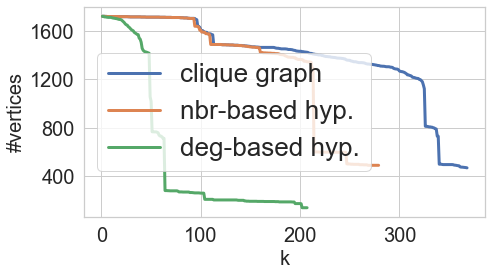

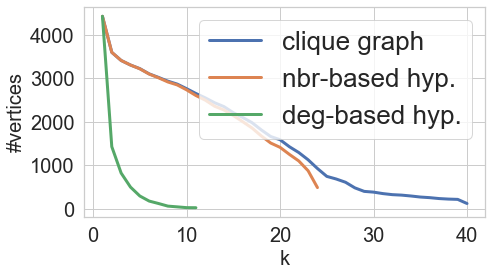

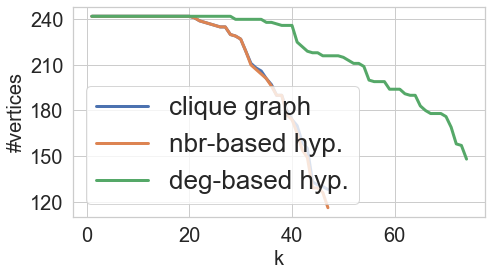

In [ ]:
import pickle
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
labelsize = 20
fontsize = 28
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize= labelsize)
# plt.rc('ytick', labelsize= labelsize)

# plt.style.use('plot.mplstyle')
lw = 3
save = False
_min = 1
_max = 100
def get_core_decomposition(core_numbers):
    _max = max(core_numbers.values())
    freq = { k : 0 for k in range(_min,_max+1)} 
    for node, val in core_numbers.items():
        for i in range(1, val+1):
            freq[i] = freq.get(i, 0)+1
    return freq

# for dataset in ['enron']:
# for dataset in ['congress','enron','contact']:
for dataset in ['congress', 'enron', 'contact']:
    algo_list = ['graph_core', 'naive_nbr', 'naive_degree']
    goodname = {
        'graph_core': 'clique graph',
        'naive_nbr': 'nbr-based hyp.',
        'naive_degree': 'deg-based hyp.'
    }

    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(1, 1, 1)
    for algo in algo_list:
        fname = "tests/tmp/" + dataset + "_" + algo + ".pkl"
        with open(fname, 'rb') as handle:
            hgDecompose = pickle.load(handle)
            core_base = hgDecompose.core
            core_decomp = get_core_decomposition(core_base)
            x = list(core_decomp.keys())
            y = [core_decomp[i] for i in x]
            plt.plot(x,y, label = goodname[algo], linewidth = lw)
    plt.xlabel('k', fontsize=labelsize)
    plt.ylabel('#vertices', fontsize=labelsize)
    plt.xticks(fontsize=labelsize)
    # plt.xticks()
    plt.yticks(fontsize=labelsize)
    # plt.legend(loc = 'upper right')
    plt.legend(fontsize = fontsize-2)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_major_locator(MaxNLocator(5)) 
    plt.tight_layout()
    if save:
        plt.savefig('results_final/qualitative/'+ good_name_dataset[dataset]+'.pdf')
    else:
        plt.show()

`Qualitative plot (only nbr-based hyp.)`

In [ ]:
# import pickle
# import matplotlib.pyplot as plt 
# from matplotlib.ticker import MaxNLocator
# labelsize = 20
# fontsize = 28
# # plt.rc('font', family='serif')
# # plt.rc('xtick', labelsize= labelsize)
# # plt.rc('ytick', labelsize= labelsize)

# # plt.style.use('plot.mplstyle')
# lw = 3
# save = False
# _min = 1
# _max = 100
# def get_core_decomposition(core_numbers):
#     _max = max(core_numbers.values())
#     freq = { k : 0 for k in range(_min,_max+1)} 
#     for node, val in core_numbers.items():
#         for i in range(1, val+1):
#             freq[i] = freq.get(i, 0)+1
#     return freq

# for dataset in ['enron']:
# # for dataset in ['congress','enron','contact']:
# # for dataset in ['congress', 'enron', 'contact']:
#     algo_list = ['naive_nbr']
#     goodname = {
#         'graph_core': 'clique graph',
#         'naive_nbr': 'nbr-based hyp.',
#         'naive_degree': 'deg-based hyp.'
#     }

#     fig = plt.figure(figsize=(7, 4))
#     ax = fig.add_subplot(1, 1, 1)
#     for algo in algo_list:
#         fname = "tests/tmp/" + dataset + "_" + algo + ".pkl"
#         with open(fname, 'rb') as handle:
#             hgDecompose = pickle.load(handle)
#             core_base = hgDecompose.core
#             core_decomp = get_core_decomposition(core_base)
#             x = list(core_decomp.keys())
#             y = [core_decomp[i] for i in x]
#             plt.plot(x,y, label = goodname[algo], linewidth = lw)
#     plt.xlabel('k', fontsize=labelsize)
#     plt.ylabel('\#vertices', fontsize=labelsize)
#     plt.xticks(fontsize=labelsize)
#     # plt.xticks()
#     plt.yticks(fontsize=labelsize)
#     # plt.legend(loc = 'upper right')
#     plt.legend(fontsize = fontsize-2)
#     ax.yaxis.set_major_locator(MaxNLocator(5))
#     ax.xaxis.set_major_locator(MaxNLocator(5)) 
#     plt.tight_layout()
#     if save:
#         plt.savefig('results_final/qualitative/'+ good_name_dataset[dataset]+'.pdf')
#     else:
#         plt.show()